In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [3]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [4]:
dataset = read_data('actitracker_walk-1.txt')
dataset = dataset.replace("\t",",",regex=True)#.replace(';',',')

In [5]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

In [6]:
dataset[:1]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Walking,4.939500e+13,-0.166767,-0.3409,0.723372


In [7]:
dataset.shape

(111638, 6)

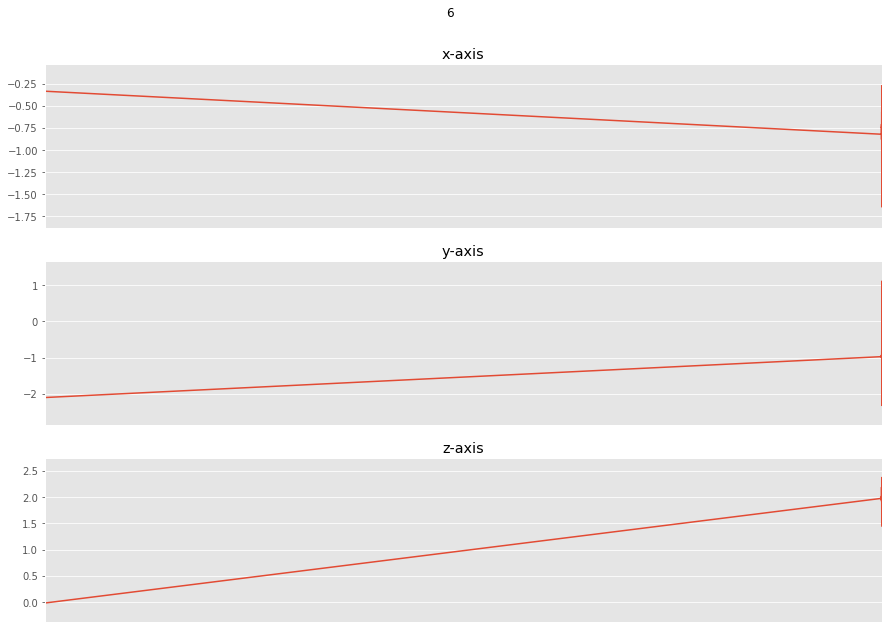

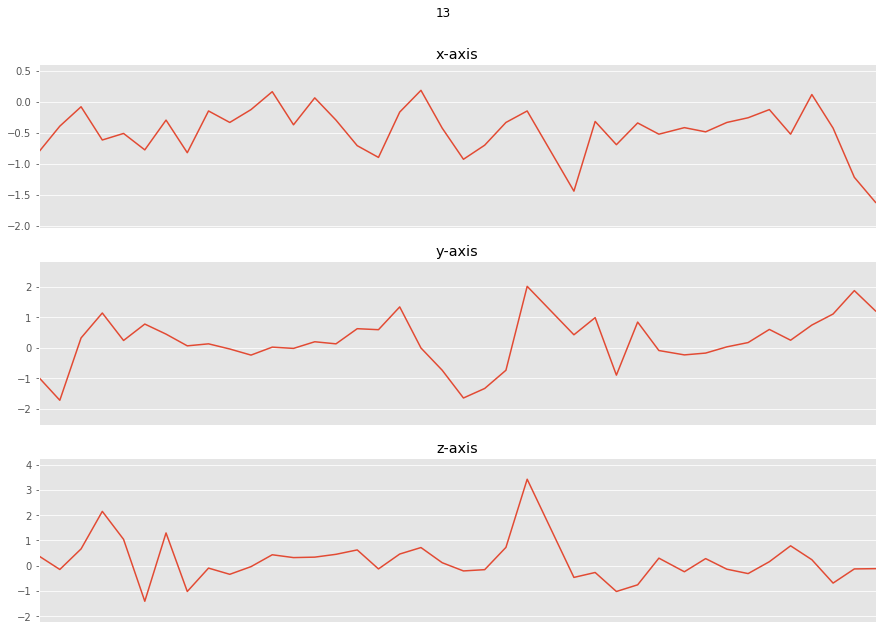

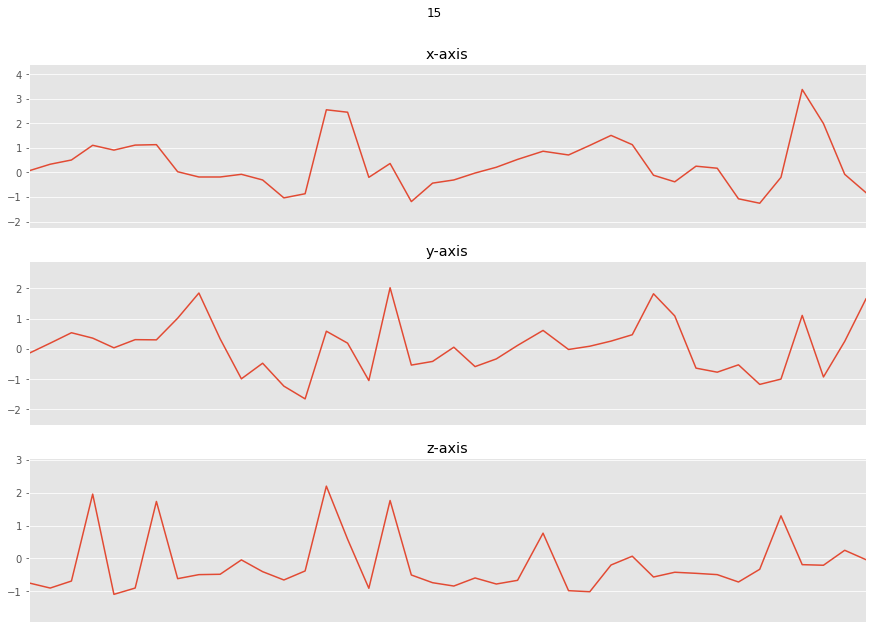

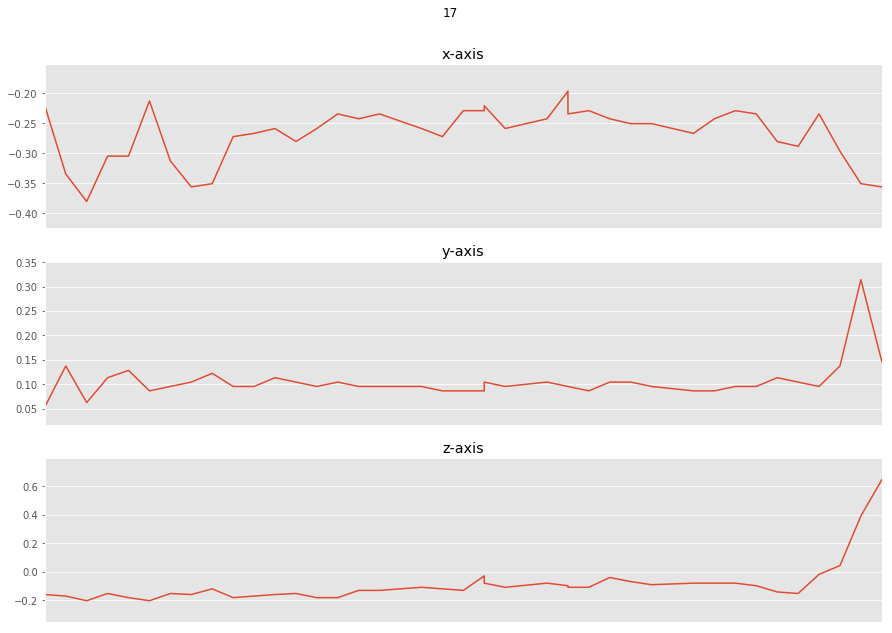

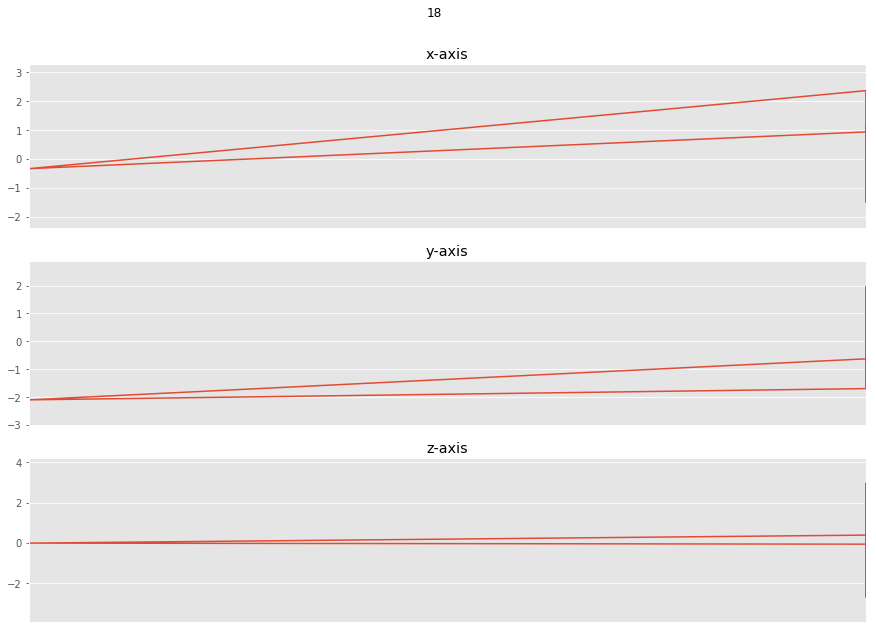

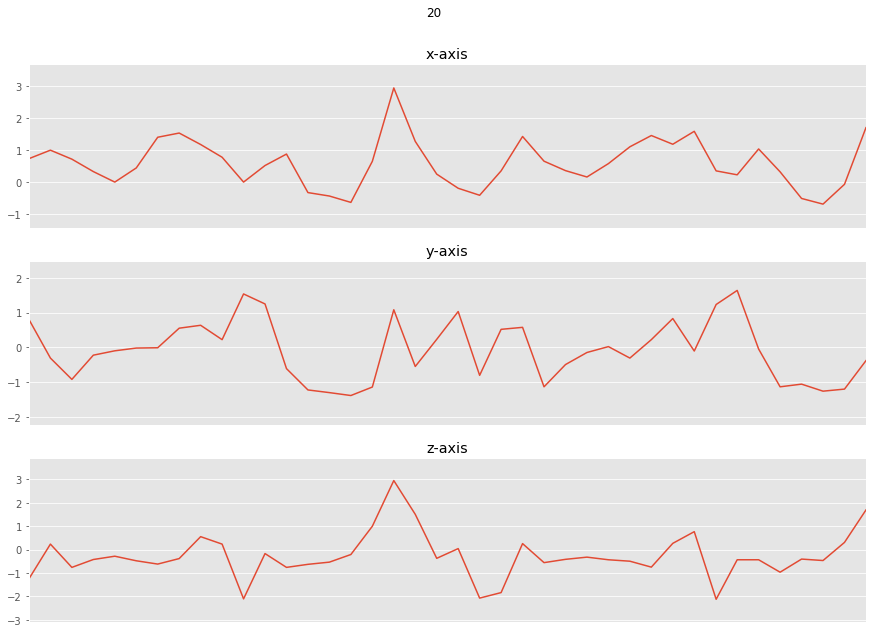

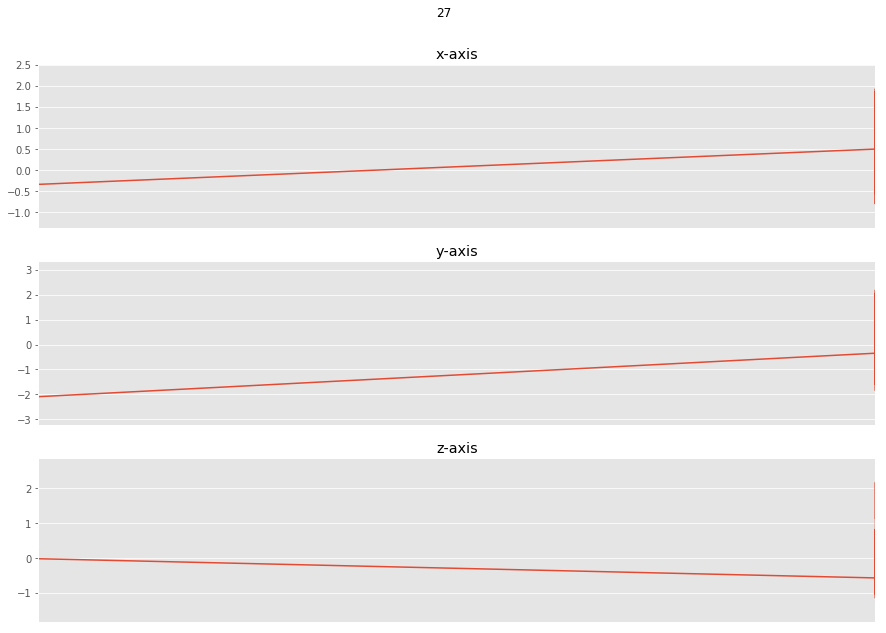

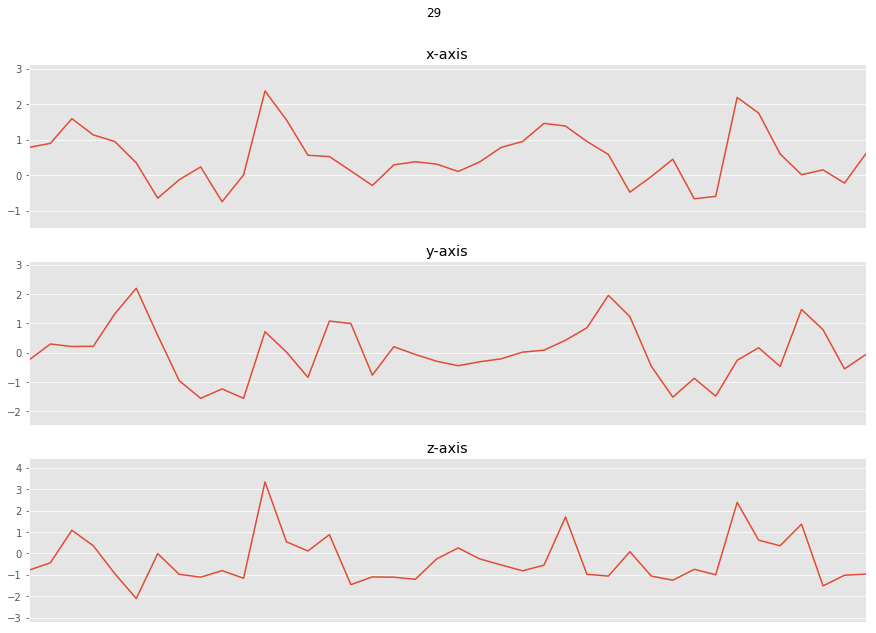

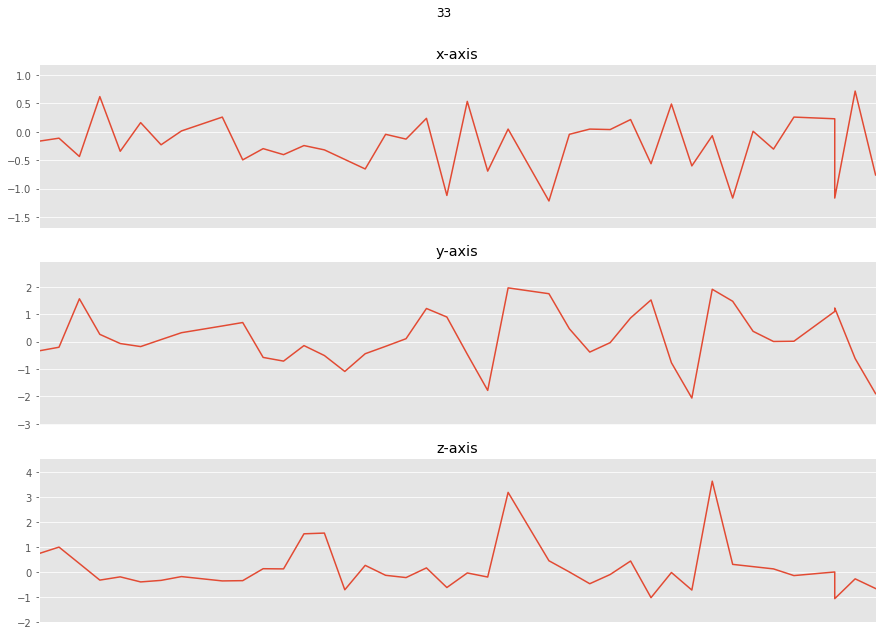

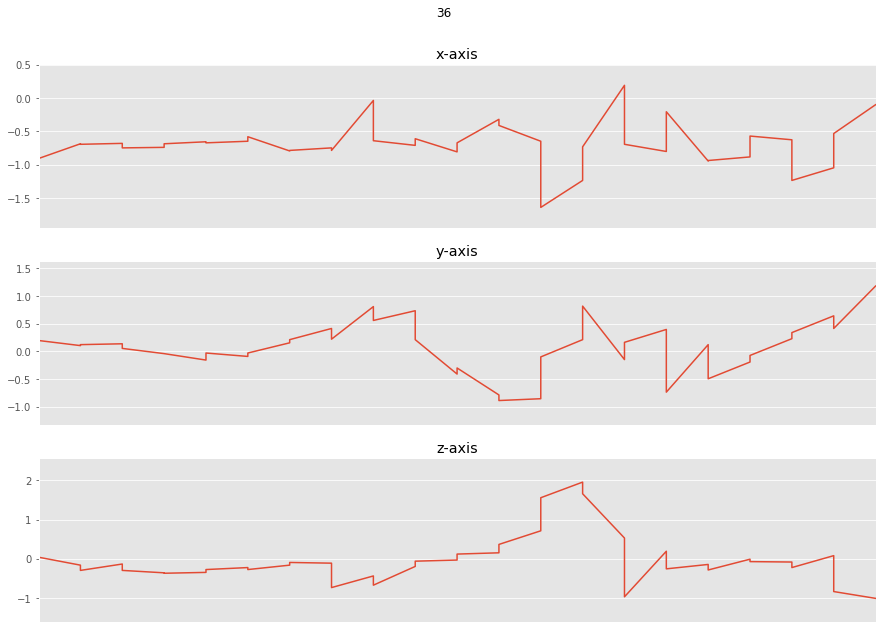

In [8]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [9]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [11]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [12]:
#saved data
np.save('train_x.npy',train_x)
np.save('train_y.npy',train_y)
np.save('test_x.npy',test_x)
np.save('test_y.npy',test_y)

In [13]:
import numpy as np
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

In [14]:
dataset[:1]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Walking,4.939500e+13,-0.166767,-0.3409,0.723372


In [14]:
type(dataset['timestamp'][0])

numpy.float64

In [ ]:
#walking label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  783.345  Training Accuracy:  0.135955
Epoch:  1  Training Loss:  416.585  Training Accuracy:  0.164607
Epoch:  2  Training Loss:  279.622  Training Accuracy:  0.202247
Epoch:  3  Training Loss:  196.635  Training Accuracy:  0.296067
Epoch:  4  Training Loss:  147.199  Training Accuracy:  0.395506
Epoch:  5  Training Loss:  118.547  Training Accuracy:  0.444382
Epoch:  6  Training Loss:  101.19  Training Accuracy:  0.468539
Epoch:  7  Training Loss:  88.0136  Training Accuracy:  0.494382
Epoch:  8  Training Loss:  77.1177  Training Accuracy:  0.515169
Epoch:  9  Training Loss:  68.254  Training Accuracy:  0.543258
Epoch:  10  Training Loss:  61.5077  Training Accuracy:  0.564607
Epoch:  11  Training Loss:  56.9802  Training Accuracy:  0.591573
Epoch:  12  Training Loss:  53.8999  Training Accuracy:  0.616292
Epoch:  13  Training Loss:  51.829  Training Accuracy:  0.647753
Epoch:  14  Training Loss:  50.3583  Training Accuracy:  0.670225
Epoch:  15  Training Lo

Epoch:  125  Training Loss:  11.7642  Training Accuracy:  0.977528
Epoch:  126  Training Loss:  11.6691  Training Accuracy:  0.978652
Epoch:  127  Training Loss:  11.5756  Training Accuracy:  0.978652
Epoch:  128  Training Loss:  11.4827  Training Accuracy:  0.978652
Epoch:  129  Training Loss:  11.3915  Training Accuracy:  0.979213
Epoch:  130  Training Loss:  11.3001  Training Accuracy:  0.979213
Epoch:  131  Training Loss:  11.2101  Training Accuracy:  0.979213
Epoch:  132  Training Loss:  11.1209  Training Accuracy:  0.979213
Epoch:  133  Training Loss:  11.0327  Training Accuracy:  0.979775
Epoch:  134  Training Loss:  10.9458  Training Accuracy:  0.979775
Epoch:  135  Training Loss:  10.8597  Training Accuracy:  0.979775
Epoch:  136  Training Loss:  10.7755  Training Accuracy:  0.980337
Epoch:  137  Training Loss:  10.6913  Training Accuracy:  0.980899
Epoch:  138  Training Loss:  10.6082  Training Accuracy:  0.980899
Epoch:  139  Training Loss:  10.5258  Training Accuracy:  0.98

Epoch:  248  Training Loss:  4.65599  Training Accuracy:  0.98764
Epoch:  249  Training Loss:  4.62152  Training Accuracy:  0.98764
Epoch:  250  Training Loss:  4.5872  Training Accuracy:  0.98764
Epoch:  251  Training Loss:  4.55304  Training Accuracy:  0.98764
Epoch:  252  Training Loss:  4.51941  Training Accuracy:  0.98764
Epoch:  253  Training Loss:  4.48579  Training Accuracy:  0.98764
Epoch:  254  Training Loss:  4.45307  Training Accuracy:  0.98764
Epoch:  255  Training Loss:  4.41995  Training Accuracy:  0.98764
Epoch:  256  Training Loss:  4.38749  Training Accuracy:  0.98764
Epoch:  257  Training Loss:  4.35467  Training Accuracy:  0.98764
Epoch:  258  Training Loss:  4.32283  Training Accuracy:  0.98764
Epoch:  259  Training Loss:  4.29058  Training Accuracy:  0.98764
Epoch:  260  Training Loss:  4.2585  Training Accuracy:  0.98764
Epoch:  261  Training Loss:  4.22732  Training Accuracy:  0.988202
Epoch:  262  Training Loss:  4.19621  Training Accuracy:  0.988202
Epoch:  26

Epoch:  371  Training Loss:  2.21212  Training Accuracy:  0.994944
Epoch:  372  Training Loss:  2.20237  Training Accuracy:  0.994944
Epoch:  373  Training Loss:  2.19282  Training Accuracy:  0.994944
Epoch:  374  Training Loss:  2.1833  Training Accuracy:  0.994944
Epoch:  375  Training Loss:  2.17386  Training Accuracy:  0.994944
Epoch:  376  Training Loss:  2.16451  Training Accuracy:  0.994944
Epoch:  377  Training Loss:  2.15523  Training Accuracy:  0.994944
Epoch:  378  Training Loss:  2.14617  Training Accuracy:  0.994944
Epoch:  379  Training Loss:  2.1372  Training Accuracy:  0.994944
Epoch:  380  Training Loss:  2.12817  Training Accuracy:  0.994944
Epoch:  381  Training Loss:  2.11934  Training Accuracy:  0.994944
Epoch:  382  Training Loss:  2.11056  Training Accuracy:  0.994944
Epoch:  383  Training Loss:  2.10176  Training Accuracy:  0.994944
Epoch:  384  Training Loss:  2.09315  Training Accuracy:  0.994944
Epoch:  385  Training Loss:  2.08452  Training Accuracy:  0.9949

Epoch:  494  Training Loss:  1.44431  Training Accuracy:  0.994944
Epoch:  495  Training Loss:  1.44025  Training Accuracy:  0.994944
Epoch:  496  Training Loss:  1.43618  Training Accuracy:  0.994944
Epoch:  497  Training Loss:  1.43225  Training Accuracy:  0.994944
Epoch:  498  Training Loss:  1.42823  Training Accuracy:  0.994944
Epoch:  499  Training Loss:  1.42422  Training Accuracy:  0.994944
Epoch:  500  Training Loss:  1.42028  Training Accuracy:  0.994944
Epoch:  501  Training Loss:  1.4164  Training Accuracy:  0.994944
Epoch:  502  Training Loss:  1.41247  Training Accuracy:  0.994944
Epoch:  503  Training Loss:  1.40853  Training Accuracy:  0.994944
Epoch:  504  Training Loss:  1.40468  Training Accuracy:  0.994944
Epoch:  505  Training Loss:  1.40083  Training Accuracy:  0.994944
Epoch:  506  Training Loss:  1.39699  Training Accuracy:  0.994944
Epoch:  507  Training Loss:  1.39318  Training Accuracy:  0.994944
Epoch:  508  Training Loss:  1.38937  Training Accuracy:  0.994

Epoch:  617  Training Loss:  1.06992  Training Accuracy:  0.994944
Epoch:  618  Training Loss:  1.06767  Training Accuracy:  0.994944
Epoch:  619  Training Loss:  1.06535  Training Accuracy:  0.994944
Epoch:  620  Training Loss:  1.06313  Training Accuracy:  0.994944
Epoch:  621  Training Loss:  1.06088  Training Accuracy:  0.994944
Epoch:  622  Training Loss:  1.05866  Training Accuracy:  0.994944
Epoch:  623  Training Loss:  1.05642  Training Accuracy:  0.994944
Epoch:  624  Training Loss:  1.05421  Training Accuracy:  0.994944
Epoch:  625  Training Loss:  1.05198  Training Accuracy:  0.994944
Epoch:  626  Training Loss:  1.0498  Training Accuracy:  0.994944
Epoch:  627  Training Loss:  1.04758  Training Accuracy:  0.994944
Epoch:  628  Training Loss:  1.04539  Training Accuracy:  0.994944
Epoch:  629  Training Loss:  1.04326  Training Accuracy:  0.994944
Epoch:  630  Training Loss:  1.04105  Training Accuracy:  0.994944
Epoch:  631  Training Loss:  1.03891  Training Accuracy:  0.994

Epoch:  739  Training Loss:  0.846555  Training Accuracy:  0.995506
Epoch:  740  Training Loss:  0.845098  Training Accuracy:  0.995506
Epoch:  741  Training Loss:  0.843637  Training Accuracy:  0.995506
Epoch:  742  Training Loss:  0.842176  Training Accuracy:  0.995506
Epoch:  743  Training Loss:  0.840726  Training Accuracy:  0.995506
Epoch:  744  Training Loss:  0.839249  Training Accuracy:  0.995506
Epoch:  745  Training Loss:  0.837829  Training Accuracy:  0.995506
Epoch:  746  Training Loss:  0.836381  Training Accuracy:  0.995506
Epoch:  747  Training Loss:  0.834945  Training Accuracy:  0.995506
Epoch:  748  Training Loss:  0.833521  Training Accuracy:  0.995506
Epoch:  749  Training Loss:  0.832103  Training Accuracy:  0.995506
Epoch:  750  Training Loss:  0.830683  Training Accuracy:  0.995506
Epoch:  751  Training Loss:  0.829293  Training Accuracy:  0.995506
Epoch:  752  Training Loss:  0.827878  Training Accuracy:  0.995506
Epoch:  753  Training Loss:  0.826477  Training 

Epoch:  860  Training Loss:  0.698606  Training Accuracy:  0.995506
Epoch:  861  Training Loss:  0.697597  Training Accuracy:  0.995506
Epoch:  862  Training Loss:  0.696566  Training Accuracy:  0.995506
Epoch:  863  Training Loss:  0.69557  Training Accuracy:  0.995506
Epoch:  864  Training Loss:  0.694546  Training Accuracy:  0.995506
Epoch:  865  Training Loss:  0.693548  Training Accuracy:  0.995506
Epoch:  866  Training Loss:  0.692541  Training Accuracy:  0.995506
Epoch:  867  Training Loss:  0.691535  Training Accuracy:  0.995506
Epoch:  868  Training Loss:  0.690547  Training Accuracy:  0.995506
Epoch:  869  Training Loss:  0.68955  Training Accuracy:  0.995506
Epoch:  870  Training Loss:  0.688549  Training Accuracy:  0.995506
Epoch:  871  Training Loss:  0.687571  Training Accuracy:  0.995506
Epoch:  872  Training Loss:  0.686571  Training Accuracy:  0.995506
Epoch:  873  Training Loss:  0.685606  Training Accuracy:  0.995506
Epoch:  874  Training Loss:  0.684614  Training Ac

Epoch:  981  Training Loss:  0.59347  Training Accuracy:  0.995506
Epoch:  982  Training Loss:  0.592726  Training Accuracy:  0.995506
Epoch:  983  Training Loss:  0.591992  Training Accuracy:  0.995506
Epoch:  984  Training Loss:  0.591252  Training Accuracy:  0.995506
Epoch:  985  Training Loss:  0.590507  Training Accuracy:  0.995506
Epoch:  986  Training Loss:  0.589773  Training Accuracy:  0.995506
Epoch:  987  Training Loss:  0.589036  Training Accuracy:  0.995506
Epoch:  988  Training Loss:  0.588309  Training Accuracy:  0.995506
Epoch:  989  Training Loss:  0.587573  Training Accuracy:  0.995506
Epoch:  990  Training Loss:  0.586852  Training Accuracy:  0.995506
Epoch:  991  Training Loss:  0.586117  Training Accuracy:  0.995506
Epoch:  992  Training Loss:  0.585393  Training Accuracy:  0.995506
Epoch:  993  Training Loss:  0.584665  Training Accuracy:  0.995506
Epoch:  994  Training Loss:  0.58394  Training Accuracy:  0.995506
Epoch:  995  Training Loss:  0.583229  Training Ac

Epoch:  1101  Training Loss:  0.515481  Training Accuracy:  0.996067
Epoch:  1102  Training Loss:  0.51493  Training Accuracy:  0.996067
Epoch:  1103  Training Loss:  0.514358  Training Accuracy:  0.996067
Epoch:  1104  Training Loss:  0.513803  Training Accuracy:  0.996067
Epoch:  1105  Training Loss:  0.513239  Training Accuracy:  0.996067
Epoch:  1106  Training Loss:  0.512686  Training Accuracy:  0.996067
Epoch:  1107  Training Loss:  0.512124  Training Accuracy:  0.996067
Epoch:  1108  Training Loss:  0.511564  Training Accuracy:  0.996067
Epoch:  1109  Training Loss:  0.511011  Training Accuracy:  0.996067
Epoch:  1110  Training Loss:  0.510452  Training Accuracy:  0.996067
Epoch:  1111  Training Loss:  0.509889  Training Accuracy:  0.996067
Epoch:  1112  Training Loss:  0.509336  Training Accuracy:  0.996067
Epoch:  1113  Training Loss:  0.508777  Training Accuracy:  0.996067
Epoch:  1114  Training Loss:  0.508225  Training Accuracy:  0.996067
Epoch:  1115  Training Loss:  0.507

Epoch:  1220  Training Loss:  0.455497  Training Accuracy:  0.996067
Epoch:  1221  Training Loss:  0.455049  Training Accuracy:  0.996067
Epoch:  1222  Training Loss:  0.454607  Training Accuracy:  0.996067
Epoch:  1223  Training Loss:  0.454156  Training Accuracy:  0.996067
Epoch:  1224  Training Loss:  0.453713  Training Accuracy:  0.996067
Epoch:  1225  Training Loss:  0.453269  Training Accuracy:  0.996067
Epoch:  1226  Training Loss:  0.45282  Training Accuracy:  0.996067
Epoch:  1227  Training Loss:  0.452379  Training Accuracy:  0.996067
Epoch:  1228  Training Loss:  0.45194  Training Accuracy:  0.996067
Epoch:  1229  Training Loss:  0.451493  Training Accuracy:  0.996067
Epoch:  1230  Training Loss:  0.451051  Training Accuracy:  0.996067
Epoch:  1231  Training Loss:  0.45061  Training Accuracy:  0.996067
Epoch:  1232  Training Loss:  0.450171  Training Accuracy:  0.996067
Epoch:  1233  Training Loss:  0.449733  Training Accuracy:  0.996067
Epoch:  1234  Training Loss:  0.44929

Epoch:  1339  Training Loss:  0.407455  Training Accuracy:  0.996067
Epoch:  1340  Training Loss:  0.407096  Training Accuracy:  0.996067
Epoch:  1341  Training Loss:  0.406735  Training Accuracy:  0.996067
Epoch:  1342  Training Loss:  0.406369  Training Accuracy:  0.996067
Epoch:  1343  Training Loss:  0.406012  Training Accuracy:  0.996067
Epoch:  1344  Training Loss:  0.405647  Training Accuracy:  0.996067
Epoch:  1345  Training Loss:  0.405292  Training Accuracy:  0.996067
Epoch:  1346  Training Loss:  0.404932  Training Accuracy:  0.996067
Epoch:  1347  Training Loss:  0.404571  Training Accuracy:  0.996067
Epoch:  1348  Training Loss:  0.404214  Training Accuracy:  0.996067
Epoch:  1349  Training Loss:  0.403858  Training Accuracy:  0.996067
Epoch:  1350  Training Loss:  0.4035  Training Accuracy:  0.996067
Epoch:  1351  Training Loss:  0.403144  Training Accuracy:  0.996067
Epoch:  1352  Training Loss:  0.402789  Training Accuracy:  0.996067


In [ ]:
#walking label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-7
training_epochs = 10000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

In [11]:
batch_y.shape

(128, 10)

In [6]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-3
training_epochs = 10000

total_batches = train_x.shape[0] // batch_size

X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  10  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  11  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  12  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  13  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  14  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  15  Training Loss:  nan  Training Accuracy:  0.0266314
Ep

Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  142  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  143  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  144  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  145  Training Loss:  nan  Traini

Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  271  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  272  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  273  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  274  Training Loss:  nan  Traini

Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  400  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  401  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  402  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  403  Training Loss:  nan  Traini

Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  529  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  530  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  531  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  532  Training Loss:  nan  Traini

Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  658  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  659  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  660  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  661  Training Loss:  nan  Traini

Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  787  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  788  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  789  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  790  Training Loss:  nan  Traini

Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  916  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  918  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  919  Training Loss:  nan  Traini

Epoch:  1032  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1033  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1034  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1035  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1036  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1037  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1038  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1039  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1040  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1041  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1042  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1043  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1044  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1045  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1046  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1047  Training Lo

Epoch:  1159  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1160  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1161  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1162  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1163  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1164  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1165  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1166  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1167  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1168  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1169  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1170  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1171  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1172  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1173  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1174  Training Lo

Epoch:  1286  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1287  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1288  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1289  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1290  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1291  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1292  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1293  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1294  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1295  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1296  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1297  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1298  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1299  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1300  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1301  Training Lo

Epoch:  1413  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1414  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1415  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1416  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1417  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1418  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1419  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1420  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1421  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1422  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1423  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1424  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1425  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1426  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1427  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1428  Training Lo

Epoch:  1540  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1541  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1542  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1543  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1544  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1545  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1546  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1547  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1548  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1549  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1550  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1551  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1552  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1553  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1554  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1555  Training Lo

Epoch:  1667  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1668  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1669  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1670  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1671  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1672  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1673  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1674  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1675  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1676  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1677  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1678  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1679  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1680  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1681  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1682  Training Lo

Epoch:  1794  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1795  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1796  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1797  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1798  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1799  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1800  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1801  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1802  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1803  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1804  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1805  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1806  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1807  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1808  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1809  Training Lo

Epoch:  1921  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1922  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1923  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1924  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1925  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1926  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1927  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1928  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1929  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1930  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1931  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1932  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1933  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1934  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1935  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1936  Training Lo

Epoch:  2048  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2049  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2050  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2051  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2052  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2053  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2054  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2055  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2056  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2057  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2058  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2059  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2060  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2061  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2062  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2063  Training Lo

Epoch:  2175  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2176  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2177  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2178  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2179  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2180  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2181  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2182  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2183  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2184  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2185  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2186  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2187  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2188  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2189  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2190  Training Lo

Epoch:  2302  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2303  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2304  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2305  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2306  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2307  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2308  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2309  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2310  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2311  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2312  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2313  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2314  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2315  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2316  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2317  Training Lo

Epoch:  2429  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2430  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2431  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2432  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2433  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2434  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2435  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2436  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2437  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2438  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2439  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2440  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2441  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2442  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2443  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2444  Training Lo

Epoch:  2556  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2557  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2558  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2559  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2560  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2561  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2562  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2563  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2564  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2565  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2566  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2567  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2568  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2569  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2570  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2571  Training Lo

Epoch:  2683  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2684  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2685  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2686  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2687  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2688  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2689  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2690  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2691  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2692  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2693  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2694  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2695  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2696  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2697  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2698  Training Lo

Epoch:  2810  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2811  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2812  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2813  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2814  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2815  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2816  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2817  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2818  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2819  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2820  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2821  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2822  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2823  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2824  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2825  Training Lo

Epoch:  2937  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2938  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2939  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2940  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2941  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2942  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2943  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2944  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2945  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2946  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2947  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2948  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2949  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2950  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2951  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2952  Training Lo

Epoch:  3064  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3065  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3066  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3067  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3068  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3069  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3070  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3071  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3072  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3073  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3074  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3075  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3076  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3077  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3078  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3079  Training Lo

Epoch:  3191  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3192  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3193  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3194  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3195  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3196  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3197  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3198  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3199  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3200  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3201  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3202  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3203  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3204  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3205  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3206  Training Lo

Epoch:  3318  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3319  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3320  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3321  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3322  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3323  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3324  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3325  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3326  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3327  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3328  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3329  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3330  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3331  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3332  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3333  Training Lo

Epoch:  3445  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3446  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3447  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3448  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3449  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3450  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3451  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3452  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3453  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3454  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3455  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3456  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3457  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3458  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3459  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3460  Training Lo

Epoch:  3572  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3573  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3574  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3575  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3576  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3577  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3578  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3579  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3580  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3581  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3582  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3583  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3584  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3585  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3586  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3587  Training Lo

Epoch:  3699  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3700  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3701  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3702  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3703  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3704  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3705  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3706  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3707  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3708  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3709  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3710  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3711  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3712  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3713  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3714  Training Lo

Epoch:  3826  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3827  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3828  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3829  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3830  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3831  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3832  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3833  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3834  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3835  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3836  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3837  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3838  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3839  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3840  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3841  Training Lo

Epoch:  3953  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3954  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3955  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3956  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3957  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3958  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3959  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3960  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3961  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3962  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3963  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3964  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3965  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3966  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3967  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3968  Training Lo

Epoch:  4080  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4081  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4082  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4083  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4084  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4085  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4086  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4087  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4088  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4089  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4090  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4091  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4092  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4093  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4094  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4095  Training Lo

Epoch:  4207  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4208  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4209  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4210  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4211  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4212  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4213  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4214  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4215  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4216  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4217  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4218  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4219  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4220  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4221  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4222  Training Lo

Epoch:  4334  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4335  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4336  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4337  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4338  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4339  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4340  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4341  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4342  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4343  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4344  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4345  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4346  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4347  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4348  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4349  Training Lo

Epoch:  4461  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4462  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4463  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4464  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4465  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4466  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4467  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4468  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4469  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4470  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4471  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4472  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4473  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4474  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4475  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4476  Training Lo

Epoch:  4588  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4589  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4590  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4591  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4592  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4593  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4594  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4595  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4596  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4597  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4598  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4599  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4600  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4601  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4602  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4603  Training Lo

Epoch:  4715  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4716  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4717  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4718  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4719  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4720  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4721  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4722  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4723  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4724  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4725  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4726  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4727  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4728  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4729  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4730  Training Lo

Epoch:  4842  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4843  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4844  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4845  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4846  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4847  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4848  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4849  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4850  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4851  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4852  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4853  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4854  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4855  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4856  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4857  Training Lo

Epoch:  4969  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4970  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4971  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4972  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4973  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4974  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4975  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4976  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4977  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4978  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4979  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4980  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4981  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4982  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4983  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4984  Training Lo

Epoch:  5096  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5097  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5098  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5099  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5100  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5101  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5102  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5103  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5104  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5105  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5106  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5107  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5108  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5109  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5110  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5111  Training Lo

Epoch:  5223  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5224  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5225  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5226  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5227  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5228  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5229  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5230  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5231  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5232  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5233  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5234  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5235  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5236  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5237  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5238  Training Lo

Epoch:  5350  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5351  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5352  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5353  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5354  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5355  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5356  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5357  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5358  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5359  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5360  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5361  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5362  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5363  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5364  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5365  Training Lo

Epoch:  5477  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5478  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5479  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5480  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5481  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5482  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5483  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5484  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5485  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5486  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5487  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5488  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5489  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5490  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5491  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5492  Training Lo

Epoch:  5604  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5605  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5606  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5607  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5608  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5609  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5610  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5611  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5612  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5613  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5614  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5615  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5616  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5617  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5618  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5619  Training Lo

Epoch:  5731  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5732  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5733  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5734  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5735  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5736  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5737  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5738  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5739  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5740  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5741  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5742  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5743  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5744  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5745  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5746  Training Lo

Epoch:  5858  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5859  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5860  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5861  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5862  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5863  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5864  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5865  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5866  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5867  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5868  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5869  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5870  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5871  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5872  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5873  Training Lo

Epoch:  5985  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5986  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5987  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5988  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5989  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5990  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5991  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5992  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5993  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5994  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5995  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5996  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5997  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5998  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5999  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6000  Training Lo

Epoch:  6112  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6113  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6114  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6115  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6116  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6117  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6118  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6119  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6120  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6121  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6122  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6123  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6124  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6125  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6126  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6127  Training Lo

Epoch:  6239  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6240  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6241  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6242  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6243  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6244  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6245  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6246  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6247  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6248  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6249  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6250  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6251  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6252  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6253  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6254  Training Lo

Epoch:  6366  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6367  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6368  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6369  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6370  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6371  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6372  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6373  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6374  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6375  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6376  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6377  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6378  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6379  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6380  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6381  Training Lo

Epoch:  6493  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6494  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6495  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6496  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6497  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6498  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6499  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6500  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6501  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6502  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6503  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6504  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6505  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6506  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6507  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6508  Training Lo

Epoch:  6620  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6621  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6622  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6623  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6624  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6625  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6626  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6627  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6628  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6629  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6630  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6631  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6632  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6633  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6634  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6635  Training Lo

Epoch:  6747  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6748  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6749  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6750  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6751  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6752  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6753  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6754  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6755  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6756  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6757  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6758  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6759  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6760  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6761  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6762  Training Lo

Epoch:  6874  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6875  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6876  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6877  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6878  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6879  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6880  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6881  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6882  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6883  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6884  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6885  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6886  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6887  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6888  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6889  Training Lo

Epoch:  7001  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7002  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7003  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7004  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7005  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7006  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7007  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7008  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7009  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7010  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7011  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7012  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7013  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7014  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7015  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7016  Training Lo

Epoch:  7128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7142  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7143  Training Lo

Epoch:  7255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7270  Training Lo

Epoch:  7382  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7383  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7397  Training Lo

Epoch:  7509  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7510  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7511  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7512  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7513  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7524  Training Lo

Epoch:  7636  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7637  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7638  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7639  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7640  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7641  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7642  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7643  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7644  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7651  Training Lo

Epoch:  7763  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7764  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7765  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7766  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7767  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7768  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7769  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7770  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7771  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7772  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7773  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7778  Training Lo

Epoch:  7890  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7891  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7892  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7893  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7894  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7895  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7896  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7897  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7898  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7899  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7900  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7901  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7902  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7905  Training Lo

Epoch:  8017  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8018  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8019  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8020  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8021  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8022  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8023  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8024  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8025  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8026  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8027  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8028  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8029  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8030  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8031  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8032  Training Lo

Epoch:  8144  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8145  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8146  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8147  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8148  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8149  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8150  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8151  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8152  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8153  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8154  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8155  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8156  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8157  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8158  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8159  Training Lo

Epoch:  8271  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8272  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8273  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8274  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8275  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8276  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8277  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8278  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8279  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8280  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8281  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8282  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8283  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8284  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8285  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8286  Training Lo

Epoch:  8398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8400  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8401  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8402  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8403  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8404  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8405  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8406  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8407  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8408  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8409  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8410  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8411  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8412  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8413  Training Lo

Epoch:  8525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8529  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8530  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8531  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8532  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8533  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8534  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8535  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8536  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8537  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8538  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8539  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8540  Training Lo

Epoch:  8652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8658  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8659  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8660  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8661  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8662  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8663  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8664  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8665  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8666  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8667  Training Lo

Epoch:  8779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8787  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8788  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8789  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8790  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8791  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8792  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8793  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8794  Training Lo

Epoch:  8906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8916  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8918  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8919  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8920  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8921  Training Lo

Epoch:  9033  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9034  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9035  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9036  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9037  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9038  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9039  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9040  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9041  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9042  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9043  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9044  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9045  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9046  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9047  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9048  Training Lo

Epoch:  9160  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9161  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9162  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9163  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9164  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9165  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9166  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9167  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9168  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9169  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9170  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9171  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9172  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9173  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9174  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9175  Training Lo

Epoch:  9287  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9288  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9289  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9290  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9291  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9292  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9293  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9294  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9295  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9296  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9297  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9298  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9299  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9300  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9301  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9302  Training Lo

Epoch:  9414  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9415  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9416  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9417  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9418  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9419  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9420  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9421  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9422  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9423  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9424  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9425  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9426  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9427  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9428  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9429  Training Lo

Epoch:  9541  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9542  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9543  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9544  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9545  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9546  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9547  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9548  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9549  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9550  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9551  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9552  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9553  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9554  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9555  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9556  Training Lo

Epoch:  9668  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9669  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9670  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9671  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9672  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9673  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9674  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9675  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9676  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9677  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9678  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9679  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9680  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9681  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9682  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9683  Training Lo

Epoch:  9795  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9796  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9797  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9798  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9799  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9800  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9801  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9802  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9803  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9804  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9805  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9806  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9807  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9808  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9809  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9810  Training Lo

Epoch:  9922  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9923  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9924  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9925  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9926  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9927  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9928  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9929  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9930  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9931  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9932  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9933  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9934  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9935  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9936  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9937  Training Lo

In [13]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 16
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1700

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  21.4897  Training Accuracy:  0.0442093
Epoch:  1  Training Loss:  20.3249  Training Accuracy:  0.0463845
Epoch:  2  Training Loss:  17.7258  Training Accuracy:  0.0452675
Epoch:  3  Training Loss:  15.1002  Training Accuracy:  0.0462081
Epoch:  4  Training Loss:  12.7212  Training Accuracy:  0.0466196
Epoch:  5  Training Loss:  10.8525  Training Accuracy:  0.0481481
Epoch:  6  Training Loss:  9.35068  Training Accuracy:  0.0505585
Epoch:  7  Training Loss:  8.06143  Training Accuracy:  0.0537331
Epoch:  8  Training Loss:  7.00692  Training Accuracy:  0.0574956
Epoch:  9  Training Loss:  6.20132  Training Accuracy:  0.0620223
Epoch:  10  Training Loss:  5.6165  Training Accuracy:  0.0660788
Epoch:  11  Training Loss:  5.16826  Training Accuracy:  0.0721928
Epoch:  12  Training Loss:  4.79484  Training Accuracy:  0.0783069
Epoch:  13  Training Loss:  4.51711  Training Accuracy:  0.0850676
Epoch:  14  Training Loss:  4.29598  Training Accuracy:  0.0905938
Epoch:

Epoch:  125  Training Loss:  1.62605  Training Accuracy:  0.485714
Epoch:  126  Training Loss:  1.63165  Training Accuracy:  0.487772
Epoch:  127  Training Loss:  1.66143  Training Accuracy:  0.489771
Epoch:  128  Training Loss:  1.62622  Training Accuracy:  0.491534
Epoch:  129  Training Loss:  1.61967  Training Accuracy:  0.493886
Epoch:  130  Training Loss:  1.62646  Training Accuracy:  0.495238
Epoch:  131  Training Loss:  1.64558  Training Accuracy:  0.49706
Epoch:  132  Training Loss:  1.61974  Training Accuracy:  0.499118
Epoch:  133  Training Loss:  1.613  Training Accuracy:  0.500882
Epoch:  134  Training Loss:  1.61629  Training Accuracy:  0.502881
Epoch:  135  Training Loss:  1.62608  Training Accuracy:  0.504468
Epoch:  136  Training Loss:  1.61109  Training Accuracy:  0.506408
Epoch:  137  Training Loss:  1.60392  Training Accuracy:  0.509053
Epoch:  138  Training Loss:  1.62296  Training Accuracy:  0.510112
Epoch:  139  Training Loss:  1.62418  Training Accuracy:  0.51187

Epoch:  248  Training Loss:  1.28914  Training Accuracy:  0.688536
Epoch:  249  Training Loss:  1.28758  Training Accuracy:  0.689947
Epoch:  250  Training Loss:  1.28461  Training Accuracy:  0.690947
Epoch:  251  Training Loss:  1.28242  Training Accuracy:  0.692593
Epoch:  252  Training Loss:  1.27943  Training Accuracy:  0.694121
Epoch:  253  Training Loss:  1.27697  Training Accuracy:  0.695121
Epoch:  254  Training Loss:  1.2755  Training Accuracy:  0.696002
Epoch:  255  Training Loss:  1.27272  Training Accuracy:  0.697178
Epoch:  256  Training Loss:  1.27087  Training Accuracy:  0.698648
Epoch:  257  Training Loss:  1.26814  Training Accuracy:  0.700176
Epoch:  258  Training Loss:  1.26647  Training Accuracy:  0.70147
Epoch:  259  Training Loss:  1.26443  Training Accuracy:  0.702587
Epoch:  260  Training Loss:  1.26189  Training Accuracy:  0.70388
Epoch:  261  Training Loss:  1.25977  Training Accuracy:  0.705585
Epoch:  262  Training Loss:  1.25735  Training Accuracy:  0.70658

Epoch:  371  Training Loss:  1.1036  Training Accuracy:  0.804939
Epoch:  372  Training Loss:  1.1015  Training Accuracy:  0.805938
Epoch:  373  Training Loss:  1.09989  Training Accuracy:  0.806467
Epoch:  374  Training Loss:  1.09808  Training Accuracy:  0.807173
Epoch:  375  Training Loss:  1.09689  Training Accuracy:  0.807996
Epoch:  376  Training Loss:  1.09488  Training Accuracy:  0.80923
Epoch:  377  Training Loss:  1.09355  Training Accuracy:  0.809936
Epoch:  378  Training Loss:  1.09166  Training Accuracy:  0.810759
Epoch:  379  Training Loss:  1.09036  Training Accuracy:  0.810935
Epoch:  380  Training Loss:  1.08851  Training Accuracy:  0.811758
Epoch:  381  Training Loss:  1.08629  Training Accuracy:  0.812464
Epoch:  382  Training Loss:  1.08513  Training Accuracy:  0.812934
Epoch:  383  Training Loss:  1.08261  Training Accuracy:  0.813581
Epoch:  384  Training Loss:  1.08069  Training Accuracy:  0.814639
Epoch:  385  Training Loss:  1.07968  Training Accuracy:  0.81581

Epoch:  493  Training Loss:  0.91895  Training Accuracy:  0.873722
Epoch:  494  Training Loss:  0.91736  Training Accuracy:  0.874075
Epoch:  495  Training Loss:  0.915845  Training Accuracy:  0.874486
Epoch:  496  Training Loss:  0.914689  Training Accuracy:  0.875074
Epoch:  497  Training Loss:  0.912481  Training Accuracy:  0.875485
Epoch:  498  Training Loss:  0.911476  Training Accuracy:  0.875897
Epoch:  499  Training Loss:  0.909963  Training Accuracy:  0.87672
Epoch:  500  Training Loss:  0.908443  Training Accuracy:  0.877073
Epoch:  501  Training Loss:  0.906542  Training Accuracy:  0.877308
Epoch:  502  Training Loss:  0.905575  Training Accuracy:  0.877661
Epoch:  503  Training Loss:  0.903146  Training Accuracy:  0.878072
Epoch:  504  Training Loss:  0.901144  Training Accuracy:  0.878249
Epoch:  505  Training Loss:  0.899161  Training Accuracy:  0.878425
Epoch:  506  Training Loss:  0.897851  Training Accuracy:  0.878836
Epoch:  507  Training Loss:  0.896472  Training Acc

Epoch:  614  Training Loss:  0.764776  Training Accuracy:  0.912464
Epoch:  615  Training Loss:  0.763001  Training Accuracy:  0.913052
Epoch:  616  Training Loss:  0.762571  Training Accuracy:  0.913346
Epoch:  617  Training Loss:  0.761409  Training Accuracy:  0.913639
Epoch:  618  Training Loss:  0.759941  Training Accuracy:  0.913757
Epoch:  619  Training Loss:  0.758699  Training Accuracy:  0.913933
Epoch:  620  Training Loss:  0.757632  Training Accuracy:  0.914227
Epoch:  621  Training Loss:  0.756478  Training Accuracy:  0.914404
Epoch:  622  Training Loss:  0.75556  Training Accuracy:  0.91458
Epoch:  623  Training Loss:  0.754462  Training Accuracy:  0.914756
Epoch:  624  Training Loss:  0.753597  Training Accuracy:  0.915168
Epoch:  625  Training Loss:  0.754179  Training Accuracy:  0.915521
Epoch:  626  Training Loss:  0.752068  Training Accuracy:  0.915697
Epoch:  627  Training Loss:  0.75123  Training Accuracy:  0.915991
Epoch:  628  Training Loss:  0.750007  Training Acc

Epoch:  735  Training Loss:  0.647399  Training Accuracy:  0.939977
Epoch:  736  Training Loss:  0.646261  Training Accuracy:  0.940095
Epoch:  737  Training Loss:  0.645666  Training Accuracy:  0.940212
Epoch:  738  Training Loss:  0.645354  Training Accuracy:  0.94033
Epoch:  739  Training Loss:  0.644233  Training Accuracy:  0.940389
Epoch:  740  Training Loss:  0.643211  Training Accuracy:  0.940741
Epoch:  741  Training Loss:  0.642424  Training Accuracy:  0.940859
Epoch:  742  Training Loss:  0.641648  Training Accuracy:  0.940976
Epoch:  743  Training Loss:  0.640414  Training Accuracy:  0.940976
Epoch:  744  Training Loss:  0.640155  Training Accuracy:  0.941153
Epoch:  745  Training Loss:  0.638689  Training Accuracy:  0.941329
Epoch:  746  Training Loss:  0.63899  Training Accuracy:  0.941388
Epoch:  747  Training Loss:  0.637702  Training Accuracy:  0.941447
Epoch:  748  Training Loss:  0.636749  Training Accuracy:  0.941505
Epoch:  749  Training Loss:  0.636023  Training Ac

Epoch:  856  Training Loss:  0.555645  Training Accuracy:  0.956438
Epoch:  857  Training Loss:  0.55497  Training Accuracy:  0.956673
Epoch:  858  Training Loss:  0.554579  Training Accuracy:  0.956732
Epoch:  859  Training Loss:  0.554351  Training Accuracy:  0.956849
Epoch:  860  Training Loss:  0.553087  Training Accuracy:  0.956967
Epoch:  861  Training Loss:  0.552856  Training Accuracy:  0.957143
Epoch:  862  Training Loss:  0.551904  Training Accuracy:  0.957143
Epoch:  863  Training Loss:  0.551374  Training Accuracy:  0.957143
Epoch:  864  Training Loss:  0.550968  Training Accuracy:  0.957261
Epoch:  865  Training Loss:  0.549752  Training Accuracy:  0.95732
Epoch:  866  Training Loss:  0.550049  Training Accuracy:  0.95732
Epoch:  867  Training Loss:  0.548865  Training Accuracy:  0.957379
Epoch:  868  Training Loss:  0.54832  Training Accuracy:  0.957379
Epoch:  869  Training Loss:  0.547961  Training Accuracy:  0.95779
Epoch:  870  Training Loss:  0.547196  Training Accur

Epoch:  977  Training Loss:  0.485162  Training Accuracy:  0.967255
Epoch:  978  Training Loss:  0.484499  Training Accuracy:  0.967373
Epoch:  979  Training Loss:  0.483777  Training Accuracy:  0.967549
Epoch:  980  Training Loss:  0.483747  Training Accuracy:  0.967549
Epoch:  981  Training Loss:  0.482974  Training Accuracy:  0.967608
Epoch:  982  Training Loss:  0.48276  Training Accuracy:  0.967667
Epoch:  983  Training Loss:  0.482133  Training Accuracy:  0.967725
Epoch:  984  Training Loss:  0.481772  Training Accuracy:  0.967784
Epoch:  985  Training Loss:  0.481217  Training Accuracy:  0.967843
Epoch:  986  Training Loss:  0.480777  Training Accuracy:  0.967843
Epoch:  987  Training Loss:  0.480145  Training Accuracy:  0.967843
Epoch:  988  Training Loss:  0.479538  Training Accuracy:  0.967961
Epoch:  989  Training Loss:  0.479233  Training Accuracy:  0.967961
Epoch:  990  Training Loss:  0.478678  Training Accuracy:  0.967961
Epoch:  991  Training Loss:  0.478102  Training A

Epoch:  1097  Training Loss:  0.430071  Training Accuracy:  0.973545
Epoch:  1098  Training Loss:  0.429185  Training Accuracy:  0.973545
Epoch:  1099  Training Loss:  0.429259  Training Accuracy:  0.973604
Epoch:  1100  Training Loss:  0.428442  Training Accuracy:  0.973604
Epoch:  1101  Training Loss:  0.428147  Training Accuracy:  0.973604
Epoch:  1102  Training Loss:  0.4281  Training Accuracy:  0.973604
Epoch:  1103  Training Loss:  0.427368  Training Accuracy:  0.973722
Epoch:  1104  Training Loss:  0.427003  Training Accuracy:  0.973781
Epoch:  1105  Training Loss:  0.426513  Training Accuracy:  0.97384
Epoch:  1106  Training Loss:  0.426221  Training Accuracy:  0.97384
Epoch:  1107  Training Loss:  0.425676  Training Accuracy:  0.973898
Epoch:  1108  Training Loss:  0.425534  Training Accuracy:  0.973898
Epoch:  1109  Training Loss:  0.425112  Training Accuracy:  0.974016
Epoch:  1110  Training Loss:  0.424588  Training Accuracy:  0.974133
Epoch:  1111  Training Loss:  0.424675

Epoch:  1217  Training Loss:  0.38625  Training Accuracy:  0.97625
Epoch:  1218  Training Loss:  0.386001  Training Accuracy:  0.97625
Epoch:  1219  Training Loss:  0.385595  Training Accuracy:  0.97625
Epoch:  1220  Training Loss:  0.385268  Training Accuracy:  0.97625
Epoch:  1221  Training Loss:  0.384964  Training Accuracy:  0.976309
Epoch:  1222  Training Loss:  0.384592  Training Accuracy:  0.976367
Epoch:  1223  Training Loss:  0.384069  Training Accuracy:  0.976367
Epoch:  1224  Training Loss:  0.384141  Training Accuracy:  0.976367
Epoch:  1225  Training Loss:  0.383264  Training Accuracy:  0.976367
Epoch:  1226  Training Loss:  0.383352  Training Accuracy:  0.976367
Epoch:  1227  Training Loss:  0.38291  Training Accuracy:  0.976367
Epoch:  1228  Training Loss:  0.382491  Training Accuracy:  0.976485
Epoch:  1229  Training Loss:  0.382064  Training Accuracy:  0.976485
Epoch:  1230  Training Loss:  0.381859  Training Accuracy:  0.976485
Epoch:  1231  Training Loss:  0.381416  

Epoch:  1337  Training Loss:  0.348429  Training Accuracy:  0.978014
Epoch:  1338  Training Loss:  0.348271  Training Accuracy:  0.978014
Epoch:  1339  Training Loss:  0.348092  Training Accuracy:  0.978014
Epoch:  1340  Training Loss:  0.347833  Training Accuracy:  0.978014
Epoch:  1341  Training Loss:  0.347435  Training Accuracy:  0.978014
Epoch:  1342  Training Loss:  0.347341  Training Accuracy:  0.978014
Epoch:  1343  Training Loss:  0.347108  Training Accuracy:  0.978072
Epoch:  1344  Training Loss:  0.34678  Training Accuracy:  0.978072
Epoch:  1345  Training Loss:  0.34642  Training Accuracy:  0.978072
Epoch:  1346  Training Loss:  0.346173  Training Accuracy:  0.978131
Epoch:  1347  Training Loss:  0.345804  Training Accuracy:  0.978131
Epoch:  1348  Training Loss:  0.345619  Training Accuracy:  0.978131
Epoch:  1349  Training Loss:  0.345436  Training Accuracy:  0.978131
Epoch:  1350  Training Loss:  0.345148  Training Accuracy:  0.978131
Epoch:  1351  Training Loss:  0.3449

Epoch:  1457  Training Loss:  0.318576  Training Accuracy:  0.979366
Epoch:  1458  Training Loss:  0.318363  Training Accuracy:  0.979366
Epoch:  1459  Training Loss:  0.318443  Training Accuracy:  0.979366
Epoch:  1460  Training Loss:  0.318135  Training Accuracy:  0.979366
Epoch:  1461  Training Loss:  0.317732  Training Accuracy:  0.979366
Epoch:  1462  Training Loss:  0.317879  Training Accuracy:  0.979366
Epoch:  1463  Training Loss:  0.317475  Training Accuracy:  0.979366
Epoch:  1464  Training Loss:  0.317281  Training Accuracy:  0.979366
Epoch:  1465  Training Loss:  0.317089  Training Accuracy:  0.979366
Epoch:  1466  Training Loss:  0.316907  Training Accuracy:  0.979366
Epoch:  1467  Training Loss:  0.316453  Training Accuracy:  0.979366
Epoch:  1468  Training Loss:  0.316447  Training Accuracy:  0.979366
Epoch:  1469  Training Loss:  0.316207  Training Accuracy:  0.979424
Epoch:  1470  Training Loss:  0.316056  Training Accuracy:  0.979424
Epoch:  1471  Training Loss:  0.31

Epoch:  1577  Training Loss:  0.293664  Training Accuracy:  0.980424
Epoch:  1578  Training Loss:  0.293387  Training Accuracy:  0.980424
Epoch:  1579  Training Loss:  0.29335  Training Accuracy:  0.980424
Epoch:  1580  Training Loss:  0.292919  Training Accuracy:  0.980424
Epoch:  1581  Training Loss:  0.292991  Training Accuracy:  0.980424
Epoch:  1582  Training Loss:  0.292707  Training Accuracy:  0.980424
Epoch:  1583  Training Loss:  0.292718  Training Accuracy:  0.980424
Epoch:  1584  Training Loss:  0.292335  Training Accuracy:  0.980424
Epoch:  1585  Training Loss:  0.292226  Training Accuracy:  0.980424
Epoch:  1586  Training Loss:  0.292004  Training Accuracy:  0.980424
Epoch:  1587  Training Loss:  0.292009  Training Accuracy:  0.980424
Epoch:  1588  Training Loss:  0.291885  Training Accuracy:  0.980424
Epoch:  1589  Training Loss:  0.29152  Training Accuracy:  0.980424
Epoch:  1590  Training Loss:  0.291297  Training Accuracy:  0.980424
Epoch:  1591  Training Loss:  0.2912

Epoch:  1697  Training Loss:  0.273365  Training Accuracy:  0.981364
Epoch:  1698  Training Loss:  0.273162  Training Accuracy:  0.981364
Epoch:  1699  Training Loss:  0.273043  Training Accuracy:  0.981364
Testing Accuracy: 0.879616


In [15]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 16
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-3
training_epochs = 1700

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

InvalidArgumentError: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 1080
  }
  dim {
    size: 10000
  }
}
float_val: 0

	 [[Node: Variable_36/Adam/Initializer/zeros = Const[_class=["loc:@Variable_36"], dtype=DT_FLOAT, value=Tensor<type: float shape: [1080,10000] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'Variable_36/Adam/Initializer/zeros', defined at:
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-53f34d6f43b5>", line 34, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 132, in _create_slots
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 766, in _zeros_slot
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 174, in create_zeros_slot
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 146, in create_slot_with_initializer
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 66, in _create_slot_var
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 277, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 701, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py", line 93, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1401, in zeros
    output = constant(zero, shape=shape, dtype=dtype, name=name)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 1080
  }
  dim {
    size: 10000
  }
}
float_val: 0

	 [[Node: Variable_36/Adam/Initializer/zeros = Const[_class=["loc:@Variable_36"], dtype=DT_FLOAT, value=Tensor<type: float shape: [1080,10000] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [16]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 16
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-3
training_epochs = 1500

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

InvalidArgumentError: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 1080
  }
  dim {
    size: 10000
  }
}
float_val: 0

	 [[Node: Variable_36/Adam/Initializer/zeros = Const[_class=["loc:@Variable_36"], dtype=DT_FLOAT, value=Tensor<type: float shape: [1080,10000] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'Variable_36/Adam/Initializer/zeros', defined at:
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-53f34d6f43b5>", line 34, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 132, in _create_slots
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 766, in _zeros_slot
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 174, in create_zeros_slot
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 146, in create_slot_with_initializer
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 66, in _create_slot_var
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 277, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 701, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py", line 93, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1401, in zeros
    output = constant(zero, shape=shape, dtype=dtype, name=name)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/deepstation/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 1080
  }
  dim {
    size: 10000
  }
}
float_val: 0

	 [[Node: Variable_36/Adam/Initializer/zeros = Const[_class=["loc:@Variable_36"], dtype=DT_FLOAT, value=Tensor<type: float shape: [1080,10000] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [33]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 9
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 3000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)


correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  124.259  Training Accuracy:  0.0404468
Epoch:  1  Training Loss:  135.933  Training Accuracy:  0.043739
Epoch:  2  Training Loss:  136.487  Training Accuracy:  0.0451499
Epoch:  3  Training Loss:  127.384  Training Accuracy:  0.0485009
Epoch:  4  Training Loss:  116.091  Training Accuracy:  0.0547913
Epoch:  5  Training Loss:  106.313  Training Accuracy:  0.0621987
Epoch:  6  Training Loss:  99.0313  Training Accuracy:  0.0676661
Epoch:  7  Training Loss:  93.637  Training Accuracy:  0.0722516
Epoch:  8  Training Loss:  89.2988  Training Accuracy:  0.077425
Epoch:  9  Training Loss:  85.5011  Training Accuracy:  0.086361
Epoch:  10  Training Loss:  81.9826  Training Accuracy:  0.093886
Epoch:  11  Training Loss:  78.6394  Training Accuracy:  0.10194
Epoch:  12  Training Loss:  75.3232  Training Accuracy:  0.109289
Epoch:  13  Training Loss:  71.956  Training Accuracy:  0.117049
Epoch:  14  Training Loss:  68.5284  Training Accuracy:  0.123398
Epoch:  15  Trai

Epoch:  127  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  142  Training Loss:  nan  Traini

Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  271  Training Loss:  nan  Traini

Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  400  Training Loss:  nan  Traini

Epoch:  514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  529  Training Loss:  nan  Traini

Epoch:  643  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  644  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  658  Training Loss:  nan  Traini

Epoch:  772  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  773  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  787  Training Loss:  nan  Traini

Epoch:  901  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  902  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  916  Training Loss:  nan  Traini

Epoch:  1029  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1030  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1031  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1032  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1033  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1034  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1035  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1036  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1037  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1038  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1039  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1040  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1041  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1042  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1043  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1044  Training Lo

Epoch:  1156  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1157  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1158  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1159  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1160  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1161  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1162  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1163  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1164  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1165  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1166  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1167  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1168  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1169  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1170  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1171  Training Lo

Epoch:  1283  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1284  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1285  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1286  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1287  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1288  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1289  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1290  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1291  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1292  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1293  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1294  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1295  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1296  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1297  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1298  Training Lo

Epoch:  1410  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1411  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1412  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1413  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1414  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1415  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1416  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1417  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1418  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1419  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1420  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1421  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1422  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1423  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1424  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1425  Training Lo

Epoch:  1537  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1538  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1539  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1540  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1541  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1542  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1543  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1544  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1545  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1546  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1547  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1548  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1549  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1550  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1551  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1552  Training Lo

Epoch:  1664  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1665  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1666  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1667  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1668  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1669  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1670  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1671  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1672  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1673  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1674  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1675  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1676  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1677  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1678  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1679  Training Lo

Epoch:  1791  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1792  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1793  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1794  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1795  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1796  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1797  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1798  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1799  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1800  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1801  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1802  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1803  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1804  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1805  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1806  Training Lo

Epoch:  1918  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1919  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1920  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1921  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1922  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1923  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1924  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1925  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1926  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1927  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1928  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1929  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1930  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1931  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1932  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1933  Training Lo

Epoch:  2045  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2046  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2047  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2048  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2049  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2050  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2051  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2052  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2053  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2054  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2055  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2056  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2057  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2058  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2059  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2060  Training Lo

Epoch:  2172  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2173  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2174  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2175  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2176  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2177  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2178  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2179  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2180  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2181  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2182  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2183  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2184  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2185  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2186  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2187  Training Lo

Epoch:  2299  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2300  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2301  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2302  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2303  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2304  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2305  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2306  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2307  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2308  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2309  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2310  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2311  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2312  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2313  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2314  Training Lo

Epoch:  2426  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2427  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2428  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2429  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2430  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2431  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2432  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2433  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2434  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2435  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2436  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2437  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2438  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2439  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2440  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2441  Training Lo

Epoch:  2553  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2554  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2555  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2556  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2557  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2558  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2559  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2560  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2561  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2562  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2563  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2564  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2565  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2566  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2567  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2568  Training Lo

Epoch:  2680  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2681  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2682  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2683  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2684  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2685  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2686  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2687  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2688  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2689  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2690  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2691  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2692  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2693  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2694  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2695  Training Lo

Epoch:  2807  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2808  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2809  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2810  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2811  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2812  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2813  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2814  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2815  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2816  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2817  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2818  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2819  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2820  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2821  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2822  Training Lo

Epoch:  2934  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2935  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2936  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2937  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2938  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2939  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2940  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2941  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2942  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2943  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2944  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2945  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2946  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2947  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2948  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2949  Training Lo

In [34]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 9
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 4000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  140.397  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  121.771  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  122.768  Training Accuracy:  0.0437978
Epoch:  3  Training Loss:  115.325  Training Accuracy:  0.0475603
Epoch:  4  Training Loss:  107.437  Training Accuracy:  0.0504997
Epoch:  5  Training Loss:  100.771  Training Accuracy:  0.0557907
Epoch:  6  Training Loss:  95.6767  Training Accuracy:  0.0620223
Epoch:  7  Training Loss:  91.5843  Training Accuracy:  0.0670782
Epoch:  8  Training Loss:  88.1849  Training Accuracy:  0.0716637
Epoch:  9  Training Loss:  85.1916  Training Accuracy:  0.0754262
Epoch:  10  Training Loss:  82.5181  Training Accuracy:  0.0790711
Epoch:  11  Training Loss:  80.0455  Training Accuracy:  0.0847737
Epoch:  12  Training Loss:  77.6623  Training Accuracy:  0.0910641
Epoch:  13  Training Loss:  75.2761  Training Accuracy:  0.0975309
Epoch:  14  Training Loss:  72.8899  Training Accuracy:  0.104938
Epoch:

Epoch:  126  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  127  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Traini

Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Traini

Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Traini

Epoch:  513  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  528  Training Loss:  nan  Traini

Epoch:  642  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  643  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  644  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  657  Training Loss:  nan  Traini

Epoch:  771  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  772  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  773  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  786  Training Loss:  nan  Traini

Epoch:  900  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  901  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  902  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  915  Training Loss:  nan  Traini

Epoch:  1028  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1029  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1030  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1031  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1032  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1033  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1034  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1035  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1036  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1037  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1038  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1039  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1040  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1041  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1042  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1043  Training Lo

Epoch:  1155  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1156  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1157  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1158  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1159  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1160  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1161  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1162  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1163  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1164  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1165  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1166  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1167  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1168  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1169  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1170  Training Lo

Epoch:  1282  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1283  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1284  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1285  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1286  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1287  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1288  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1289  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1290  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1291  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1292  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1293  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1294  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1295  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1296  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1297  Training Lo

Epoch:  1409  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1410  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1411  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1412  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1413  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1414  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1415  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1416  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1417  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1418  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1419  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1420  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1421  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1422  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1423  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1424  Training Lo

Epoch:  1536  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1537  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1538  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1539  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1540  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1541  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1542  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1543  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1544  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1545  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1546  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1547  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1548  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1549  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1550  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1551  Training Lo

Epoch:  1663  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1664  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1665  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1666  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1667  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1668  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1669  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1670  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1671  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1672  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1673  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1674  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1675  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1676  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1677  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1678  Training Lo

Epoch:  1790  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1791  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1792  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1793  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1794  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1795  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1796  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1797  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1798  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1799  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1800  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1801  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1802  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1803  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1804  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1805  Training Lo

Epoch:  1917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1918  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1919  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1920  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1921  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1922  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1923  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1924  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1925  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1926  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1927  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1928  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1929  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1930  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1931  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1932  Training Lo

Epoch:  2044  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2045  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2046  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2047  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2048  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2049  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2050  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2051  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2052  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2053  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2054  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2055  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2056  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2057  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2058  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2059  Training Lo

Epoch:  2171  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2172  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2173  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2174  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2175  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2176  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2177  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2178  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2179  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2180  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2181  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2182  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2183  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2184  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2185  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2186  Training Lo

Epoch:  2298  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2299  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2300  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2301  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2302  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2303  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2304  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2305  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2306  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2307  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2308  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2309  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2310  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2311  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2312  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2313  Training Lo

Epoch:  2425  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2426  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2427  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2428  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2429  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2430  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2431  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2432  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2433  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2434  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2435  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2436  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2437  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2438  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2439  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2440  Training Lo

Epoch:  2552  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2553  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2554  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2555  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2556  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2557  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2558  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2559  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2560  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2561  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2562  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2563  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2564  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2565  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2566  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2567  Training Lo

Epoch:  2679  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2680  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2681  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2682  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2683  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2684  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2685  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2686  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2687  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2688  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2689  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2690  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2691  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2692  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2693  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2694  Training Lo

Epoch:  2806  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2807  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2808  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2809  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2810  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2811  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2812  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2813  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2814  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2815  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2816  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2817  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2818  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2819  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2820  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2821  Training Lo

Epoch:  2933  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2934  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2935  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2936  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2937  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2938  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2939  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2940  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2941  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2942  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2943  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2944  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2945  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2946  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2947  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2948  Training Lo

Epoch:  3060  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3061  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3062  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3063  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3064  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3065  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3066  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3067  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3068  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3069  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3070  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3071  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3072  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3073  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3074  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3075  Training Lo

Epoch:  3187  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3188  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3189  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3190  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3191  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3192  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3193  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3194  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3195  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3196  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3197  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3198  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3199  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3200  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3201  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3202  Training Lo

Epoch:  3314  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3315  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3316  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3317  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3318  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3319  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3320  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3321  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3322  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3323  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3324  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3325  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3326  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3327  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3328  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3329  Training Lo

Epoch:  3441  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3442  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3443  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3444  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3445  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3446  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3447  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3448  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3449  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3450  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3451  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3452  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3453  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3454  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3455  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3456  Training Lo

Epoch:  3568  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3569  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3570  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3571  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3572  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3573  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3574  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3575  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3576  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3577  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3578  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3579  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3580  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3581  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3582  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3583  Training Lo

Epoch:  3695  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3696  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3697  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3698  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3699  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3700  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3701  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3702  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3703  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3704  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3705  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3706  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3707  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3708  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3709  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3710  Training Lo

Epoch:  3822  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3823  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3824  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3825  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3826  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3827  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3828  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3829  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3830  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3831  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3832  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3833  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3834  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3835  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3836  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3837  Training Lo

Epoch:  3949  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3950  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3951  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3952  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3953  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3954  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3955  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3956  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3957  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3958  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3959  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3960  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3961  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3962  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3963  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3964  Training Lo

In [39]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-3
training_epochs = 5000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  10  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  11  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  12  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  13  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  14  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  15  Training Loss:  nan  Training Accuracy:  0.0266314
Ep

Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  142  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  143  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  144  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  145  Training Loss:  nan  Traini

Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  271  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  272  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  273  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  274  Training Loss:  nan  Traini

Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  400  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  401  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  402  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  403  Training Loss:  nan  Traini

Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  529  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  530  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  531  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  532  Training Loss:  nan  Traini

Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  658  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  659  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  660  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  661  Training Loss:  nan  Traini

Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  787  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  788  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  789  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  790  Training Loss:  nan  Traini

Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  916  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  918  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  919  Training Loss:  nan  Traini

Epoch:  1032  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1033  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1034  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1035  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1036  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1037  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1038  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1039  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1040  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1041  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1042  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1043  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1044  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1045  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1046  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1047  Training Lo

Epoch:  1159  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1160  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1161  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1162  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1163  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1164  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1165  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1166  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1167  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1168  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1169  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1170  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1171  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1172  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1173  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1174  Training Lo

Epoch:  1286  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1287  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1288  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1289  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1290  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1291  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1292  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1293  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1294  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1295  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1296  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1297  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1298  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1299  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1300  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1301  Training Lo

Epoch:  1413  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1414  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1415  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1416  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1417  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1418  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1419  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1420  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1421  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1422  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1423  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1424  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1425  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1426  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1427  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1428  Training Lo

Epoch:  1540  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1541  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1542  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1543  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1544  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1545  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1546  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1547  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1548  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1549  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1550  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1551  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1552  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1553  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1554  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1555  Training Lo

Epoch:  1667  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1668  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1669  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1670  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1671  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1672  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1673  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1674  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1675  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1676  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1677  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1678  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1679  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1680  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1681  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1682  Training Lo

Epoch:  1794  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1795  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1796  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1797  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1798  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1799  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1800  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1801  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1802  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1803  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1804  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1805  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1806  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1807  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1808  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1809  Training Lo

Epoch:  1921  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1922  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1923  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1924  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1925  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1926  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1927  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1928  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1929  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1930  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1931  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1932  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1933  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1934  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1935  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1936  Training Lo

Epoch:  2048  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2049  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2050  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2051  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2052  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2053  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2054  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2055  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2056  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2057  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2058  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2059  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2060  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2061  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2062  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2063  Training Lo

Epoch:  2175  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2176  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2177  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2178  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2179  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2180  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2181  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2182  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2183  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2184  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2185  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2186  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2187  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2188  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2189  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2190  Training Lo

Epoch:  2302  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2303  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2304  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2305  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2306  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2307  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2308  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2309  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2310  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2311  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2312  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2313  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2314  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2315  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2316  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2317  Training Lo

Epoch:  2429  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2430  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2431  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2432  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2433  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2434  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2435  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2436  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2437  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2438  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2439  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2440  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2441  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2442  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2443  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2444  Training Lo

Epoch:  2556  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2557  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2558  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2559  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2560  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2561  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2562  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2563  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2564  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2565  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2566  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2567  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2568  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2569  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2570  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2571  Training Lo

Epoch:  2683  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2684  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2685  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2686  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2687  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2688  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2689  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2690  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2691  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2692  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2693  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2694  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2695  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2696  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2697  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2698  Training Lo

Epoch:  2810  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2811  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2812  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2813  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2814  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2815  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2816  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2817  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2818  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2819  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2820  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2821  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2822  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2823  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2824  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2825  Training Lo

Epoch:  2937  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2938  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2939  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2940  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2941  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2942  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2943  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2944  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2945  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2946  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2947  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2948  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2949  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2950  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2951  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2952  Training Lo

Epoch:  3064  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3065  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3066  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3067  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3068  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3069  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3070  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3071  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3072  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3073  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3074  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3075  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3076  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3077  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3078  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3079  Training Lo

Epoch:  3191  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3192  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3193  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3194  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3195  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3196  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3197  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3198  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3199  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3200  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3201  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3202  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3203  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3204  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3205  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3206  Training Lo

Epoch:  3318  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3319  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3320  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3321  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3322  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3323  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3324  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3325  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3326  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3327  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3328  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3329  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3330  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3331  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3332  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3333  Training Lo

Epoch:  3445  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3446  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3447  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3448  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3449  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3450  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3451  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3452  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3453  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3454  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3455  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3456  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3457  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3458  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3459  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3460  Training Lo

Epoch:  3572  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3573  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3574  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3575  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3576  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3577  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3578  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3579  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3580  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3581  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3582  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3583  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3584  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3585  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3586  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3587  Training Lo

Epoch:  3699  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3700  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3701  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3702  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3703  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3704  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3705  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3706  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3707  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3708  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3709  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3710  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3711  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3712  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3713  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3714  Training Lo

Epoch:  3826  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3827  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3828  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3829  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3830  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3831  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3832  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3833  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3834  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3835  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3836  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3837  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3838  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3839  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3840  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3841  Training Lo

Epoch:  3953  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3954  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3955  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3956  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3957  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3958  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3959  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3960  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3961  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3962  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3963  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3964  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3965  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3966  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3967  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3968  Training Lo

Epoch:  4080  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4081  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4082  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4083  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4084  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4085  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4086  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4087  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4088  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4089  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4090  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4091  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4092  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4093  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4094  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4095  Training Lo

Epoch:  4207  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4208  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4209  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4210  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4211  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4212  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4213  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4214  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4215  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4216  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4217  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4218  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4219  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4220  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4221  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4222  Training Lo

Epoch:  4334  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4335  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4336  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4337  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4338  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4339  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4340  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4341  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4342  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4343  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4344  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4345  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4346  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4347  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4348  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4349  Training Lo

Epoch:  4461  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4462  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4463  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4464  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4465  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4466  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4467  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4468  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4469  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4470  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4471  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4472  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4473  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4474  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4475  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4476  Training Lo

Epoch:  4588  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4589  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4590  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4591  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4592  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4593  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4594  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4595  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4596  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4597  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4598  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4599  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4600  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4601  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4602  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4603  Training Lo

Epoch:  4715  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4716  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4717  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4718  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4719  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4720  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4721  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4722  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4723  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4724  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4725  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4726  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4727  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4728  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4729  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4730  Training Lo

Epoch:  4842  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4843  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4844  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4845  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4846  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4847  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4848  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4849  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4850  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4851  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4852  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4853  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4854  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4855  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4856  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4857  Training Lo

Epoch:  4969  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4970  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4971  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4972  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4973  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4974  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4975  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4976  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4977  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4978  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4979  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4980  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4981  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4982  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4983  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4984  Training Lo

In [37]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-3
training_epochs = 10000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  10  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  11  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  12  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  13  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  14  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  15  Training Loss:  nan  Training Accuracy:  0.0266314
Ep

Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  142  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  143  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  144  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  145  Training Loss:  nan  Traini

Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  271  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  272  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  273  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  274  Training Loss:  nan  Traini

Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  400  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  401  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  402  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  403  Training Loss:  nan  Traini

Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  529  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  530  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  531  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  532  Training Loss:  nan  Traini

Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  658  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  659  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  660  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  661  Training Loss:  nan  Traini

Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  787  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  788  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  789  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  790  Training Loss:  nan  Traini

Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  916  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  918  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  919  Training Loss:  nan  Traini

Epoch:  1032  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1033  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1034  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1035  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1036  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1037  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1038  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1039  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1040  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1041  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1042  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1043  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1044  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1045  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1046  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1047  Training Lo

Epoch:  1159  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1160  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1161  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1162  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1163  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1164  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1165  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1166  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1167  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1168  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1169  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1170  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1171  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1172  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1173  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1174  Training Lo

Epoch:  1286  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1287  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1288  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1289  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1290  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1291  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1292  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1293  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1294  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1295  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1296  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1297  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1298  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1299  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1300  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1301  Training Lo

Epoch:  1413  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1414  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1415  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1416  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1417  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1418  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1419  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1420  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1421  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1422  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1423  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1424  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1425  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1426  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1427  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1428  Training Lo

Epoch:  1540  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1541  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1542  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1543  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1544  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1545  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1546  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1547  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1548  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1549  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1550  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1551  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1552  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1553  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1554  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1555  Training Lo

Epoch:  1667  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1668  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1669  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1670  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1671  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1672  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1673  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1674  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1675  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1676  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1677  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1678  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1679  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1680  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1681  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1682  Training Lo

Epoch:  1794  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1795  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1796  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1797  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1798  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1799  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1800  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1801  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1802  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1803  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1804  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1805  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1806  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1807  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1808  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1809  Training Lo

Epoch:  1921  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1922  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1923  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1924  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1925  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1926  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1927  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1928  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1929  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1930  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1931  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1932  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1933  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1934  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1935  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1936  Training Lo

Epoch:  2048  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2049  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2050  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2051  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2052  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2053  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2054  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2055  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2056  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2057  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2058  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2059  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2060  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2061  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2062  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2063  Training Lo

Epoch:  2175  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2176  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2177  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2178  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2179  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2180  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2181  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2182  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2183  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2184  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2185  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2186  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2187  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2188  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2189  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2190  Training Lo

Epoch:  2302  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2303  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2304  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2305  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2306  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2307  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2308  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2309  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2310  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2311  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2312  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2313  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2314  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2315  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2316  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2317  Training Lo

Epoch:  2429  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2430  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2431  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2432  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2433  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2434  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2435  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2436  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2437  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2438  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2439  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2440  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2441  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2442  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2443  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2444  Training Lo

Epoch:  2556  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2557  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2558  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2559  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2560  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2561  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2562  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2563  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2564  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2565  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2566  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2567  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2568  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2569  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2570  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2571  Training Lo

Epoch:  2683  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2684  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2685  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2686  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2687  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2688  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2689  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2690  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2691  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2692  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2693  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2694  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2695  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2696  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2697  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2698  Training Lo

Epoch:  2810  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2811  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2812  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2813  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2814  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2815  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2816  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2817  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2818  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2819  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2820  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2821  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2822  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2823  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2824  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2825  Training Lo

Epoch:  2937  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2938  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2939  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2940  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2941  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2942  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2943  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2944  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2945  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2946  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2947  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2948  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2949  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2950  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2951  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2952  Training Lo

Epoch:  3064  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3065  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3066  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3067  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3068  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3069  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3070  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3071  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3072  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3073  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3074  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3075  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3076  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3077  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3078  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3079  Training Lo

Epoch:  3191  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3192  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3193  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3194  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3195  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3196  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3197  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3198  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3199  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3200  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3201  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3202  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3203  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3204  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3205  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3206  Training Lo

Epoch:  3318  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3319  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3320  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3321  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3322  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3323  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3324  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3325  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3326  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3327  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3328  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3329  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3330  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3331  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3332  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3333  Training Lo

Epoch:  3445  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3446  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3447  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3448  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3449  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3450  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3451  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3452  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3453  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3454  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3455  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3456  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3457  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3458  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3459  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3460  Training Lo

Epoch:  3572  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3573  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3574  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3575  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3576  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3577  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3578  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3579  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3580  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3581  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3582  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3583  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3584  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3585  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3586  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3587  Training Lo

Epoch:  3699  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3700  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3701  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3702  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3703  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3704  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3705  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3706  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3707  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3708  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3709  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3710  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3711  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3712  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3713  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3714  Training Lo

Epoch:  3826  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3827  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3828  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3829  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3830  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3831  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3832  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3833  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3834  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3835  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3836  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3837  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3838  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3839  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3840  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3841  Training Lo

Epoch:  3953  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3954  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3955  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3956  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3957  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3958  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3959  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3960  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3961  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3962  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3963  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3964  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3965  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3966  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3967  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3968  Training Lo

Epoch:  4080  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4081  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4082  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4083  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4084  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4085  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4086  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4087  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4088  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4089  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4090  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4091  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4092  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4093  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4094  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4095  Training Lo

Epoch:  4207  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4208  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4209  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4210  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4211  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4212  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4213  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4214  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4215  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4216  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4217  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4218  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4219  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4220  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4221  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4222  Training Lo

Epoch:  4334  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4335  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4336  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4337  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4338  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4339  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4340  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4341  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4342  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4343  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4344  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4345  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4346  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4347  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4348  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4349  Training Lo

Epoch:  4461  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4462  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4463  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4464  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4465  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4466  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4467  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4468  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4469  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4470  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4471  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4472  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4473  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4474  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4475  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4476  Training Lo

Epoch:  4588  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4589  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4590  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4591  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4592  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4593  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4594  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4595  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4596  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4597  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4598  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4599  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4600  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4601  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4602  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4603  Training Lo

Epoch:  4715  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4716  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4717  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4718  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4719  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4720  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4721  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4722  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4723  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4724  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4725  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4726  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4727  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4728  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4729  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4730  Training Lo

Epoch:  4842  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4843  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4844  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4845  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4846  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4847  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4848  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4849  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4850  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4851  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4852  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4853  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4854  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4855  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4856  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4857  Training Lo

Epoch:  4969  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4970  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4971  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4972  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4973  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4974  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4975  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4976  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4977  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4978  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4979  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4980  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4981  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4982  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4983  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4984  Training Lo

Epoch:  5096  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5097  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5098  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5099  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5100  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5101  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5102  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5103  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5104  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5105  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5106  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5107  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5108  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5109  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5110  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5111  Training Lo

Epoch:  5223  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5224  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5225  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5226  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5227  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5228  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5229  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5230  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5231  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5232  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5233  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5234  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5235  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5236  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5237  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5238  Training Lo

Epoch:  5350  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5351  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5352  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5353  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5354  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5355  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5356  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5357  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5358  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5359  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5360  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5361  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5362  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5363  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5364  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5365  Training Lo

Epoch:  5477  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5478  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5479  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5480  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5481  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5482  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5483  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5484  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5485  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5486  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5487  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5488  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5489  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5490  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5491  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5492  Training Lo

Epoch:  5604  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5605  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5606  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5607  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5608  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5609  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5610  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5611  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5612  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5613  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5614  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5615  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5616  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5617  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5618  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5619  Training Lo

Epoch:  5731  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5732  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5733  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5734  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5735  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5736  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5737  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5738  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5739  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5740  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5741  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5742  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5743  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5744  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5745  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5746  Training Lo

Epoch:  5858  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5859  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5860  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5861  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5862  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5863  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5864  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5865  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5866  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5867  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5868  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5869  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5870  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5871  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5872  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5873  Training Lo

Epoch:  5985  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5986  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5987  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5988  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5989  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5990  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5991  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5992  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5993  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5994  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5995  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5996  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5997  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5998  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5999  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6000  Training Lo

Epoch:  6112  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6113  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6114  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6115  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6116  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6117  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6118  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6119  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6120  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6121  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6122  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6123  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6124  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6125  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6126  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6127  Training Lo

Epoch:  6239  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6240  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6241  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6242  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6243  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6244  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6245  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6246  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6247  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6248  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6249  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6250  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6251  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6252  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6253  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6254  Training Lo

Epoch:  6366  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6367  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6368  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6369  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6370  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6371  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6372  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6373  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6374  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6375  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6376  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6377  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6378  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6379  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6380  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6381  Training Lo

Epoch:  6493  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6494  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6495  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6496  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6497  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6498  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6499  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6500  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6501  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6502  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6503  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6504  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6505  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6506  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6507  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6508  Training Lo

Epoch:  6620  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6621  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6622  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6623  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6624  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6625  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6626  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6627  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6628  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6629  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6630  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6631  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6632  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6633  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6634  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6635  Training Lo

Epoch:  6747  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6748  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6749  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6750  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6751  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6752  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6753  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6754  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6755  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6756  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6757  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6758  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6759  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6760  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6761  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6762  Training Lo

Epoch:  6874  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6875  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6876  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6877  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6878  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6879  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6880  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6881  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6882  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6883  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6884  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6885  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6886  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6887  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6888  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6889  Training Lo

Epoch:  7001  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7002  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7003  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7004  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7005  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7006  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7007  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7008  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7009  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7010  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7011  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7012  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7013  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7014  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7015  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7016  Training Lo

Epoch:  7128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7142  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7143  Training Lo

Epoch:  7255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7270  Training Lo

Epoch:  7382  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7383  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7397  Training Lo

Epoch:  7509  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7510  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7511  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7512  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7513  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7524  Training Lo

Epoch:  7636  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7637  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7638  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7639  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7640  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7641  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7642  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7643  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7644  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7651  Training Lo

Epoch:  7763  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7764  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7765  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7766  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7767  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7768  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7769  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7770  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7771  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7772  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7773  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7778  Training Lo

Epoch:  7890  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7891  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7892  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7893  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7894  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7895  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7896  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7897  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7898  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7899  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7900  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7901  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7902  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7905  Training Lo

Epoch:  8017  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8018  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8019  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8020  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8021  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8022  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8023  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8024  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8025  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8026  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8027  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8028  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8029  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8030  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8031  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8032  Training Lo

Epoch:  8144  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8145  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8146  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8147  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8148  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8149  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8150  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8151  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8152  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8153  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8154  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8155  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8156  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8157  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8158  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8159  Training Lo

Epoch:  8271  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8272  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8273  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8274  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8275  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8276  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8277  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8278  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8279  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8280  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8281  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8282  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8283  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8284  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8285  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8286  Training Lo

Epoch:  8398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8400  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8401  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8402  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8403  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8404  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8405  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8406  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8407  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8408  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8409  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8410  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8411  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8412  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8413  Training Lo

Epoch:  8525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8529  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8530  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8531  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8532  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8533  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8534  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8535  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8536  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8537  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8538  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8539  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8540  Training Lo

Epoch:  8652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8658  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8659  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8660  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8661  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8662  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8663  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8664  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8665  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8666  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8667  Training Lo

Epoch:  8779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8787  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8788  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8789  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8790  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8791  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8792  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8793  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8794  Training Lo

Epoch:  8906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8916  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8918  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8919  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8920  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8921  Training Lo

Epoch:  9033  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9034  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9035  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9036  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9037  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9038  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9039  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9040  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9041  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9042  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9043  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9044  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9045  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9046  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9047  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9048  Training Lo

Epoch:  9160  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9161  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9162  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9163  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9164  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9165  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9166  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9167  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9168  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9169  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9170  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9171  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9172  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9173  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9174  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9175  Training Lo

Epoch:  9287  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9288  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9289  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9290  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9291  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9292  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9293  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9294  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9295  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9296  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9297  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9298  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9299  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9300  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9301  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9302  Training Lo

Epoch:  9414  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9415  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9416  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9417  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9418  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9419  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9420  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9421  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9422  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9423  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9424  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9425  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9426  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9427  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9428  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9429  Training Lo

Epoch:  9541  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9542  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9543  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9544  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9545  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9546  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9547  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9548  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9549  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9550  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9551  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9552  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9553  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9554  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9555  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9556  Training Lo

Epoch:  9668  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9669  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9670  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9671  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9672  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9673  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9674  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9675  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9676  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9677  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9678  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9679  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9680  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9681  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9682  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9683  Training Lo

Epoch:  9795  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9796  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9797  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9798  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9799  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9800  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9801  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9802  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9803  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9804  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9805  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9806  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9807  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9808  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9809  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9810  Training Lo

Epoch:  9922  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9923  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9924  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9925  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9926  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9927  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9928  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9929  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9930  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9931  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9932  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9933  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9934  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9935  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9936  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9937  Training Lo

In [40]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-3
training_epochs = 2500

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  3  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  4  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  5  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  6  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  7  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  8  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  9  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  10  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  11  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  12  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  13  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  14  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  15  Training Loss:  nan  Training Accuracy:  0.0266314
Ep

Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  142  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  143  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  144  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  145  Training Loss:  nan  Traini

Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  271  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  272  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  273  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  274  Training Loss:  nan  Traini

Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  400  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  401  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  402  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  403  Training Loss:  nan  Traini

Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  529  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  530  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  531  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  532  Training Loss:  nan  Traini

Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  658  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  659  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  660  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  661  Training Loss:  nan  Traini

Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  787  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  788  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  789  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  790  Training Loss:  nan  Traini

Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  916  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  918  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  919  Training Loss:  nan  Traini

Epoch:  1032  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1033  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1034  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1035  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1036  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1037  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1038  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1039  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1040  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1041  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1042  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1043  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1044  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1045  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1046  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1047  Training Lo

Epoch:  1159  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1160  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1161  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1162  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1163  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1164  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1165  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1166  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1167  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1168  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1169  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1170  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1171  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1172  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1173  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1174  Training Lo

Epoch:  1286  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1287  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1288  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1289  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1290  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1291  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1292  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1293  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1294  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1295  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1296  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1297  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1298  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1299  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1300  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1301  Training Lo

Epoch:  1413  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1414  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1415  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1416  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1417  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1418  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1419  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1420  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1421  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1422  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1423  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1424  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1425  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1426  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1427  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1428  Training Lo

Epoch:  1540  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1541  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1542  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1543  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1544  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1545  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1546  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1547  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1548  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1549  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1550  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1551  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1552  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1553  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1554  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1555  Training Lo

Epoch:  1667  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1668  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1669  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1670  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1671  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1672  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1673  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1674  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1675  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1676  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1677  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1678  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1679  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1680  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1681  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1682  Training Lo

Epoch:  1794  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1795  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1796  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1797  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1798  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1799  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1800  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1801  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1802  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1803  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1804  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1805  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1806  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1807  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1808  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1809  Training Lo

Epoch:  1921  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1922  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1923  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1924  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1925  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1926  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1927  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1928  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1929  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1930  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1931  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1932  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1933  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1934  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1935  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  1936  Training Lo

Epoch:  2048  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2049  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2050  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2051  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2052  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2053  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2054  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2055  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2056  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2057  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2058  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2059  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2060  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2061  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2062  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2063  Training Lo

Epoch:  2175  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2176  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2177  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2178  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2179  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2180  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2181  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2182  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2183  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2184  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2185  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2186  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2187  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2188  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2189  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2190  Training Lo

Epoch:  2302  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2303  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2304  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2305  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2306  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2307  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2308  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2309  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2310  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2311  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2312  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2313  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2314  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2315  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2316  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2317  Training Lo

Epoch:  2429  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2430  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2431  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2432  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2433  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2434  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2435  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2436  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2437  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2438  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2439  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2440  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2441  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2442  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2443  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  2444  Training Lo

In [18]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  175.615  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  141.838  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  127.823  Training Accuracy:  0.0462669
Epoch:  3  Training Loss:  114.735  Training Accuracy:  0.0530864
Epoch:  4  Training Loss:  104.378  Training Accuracy:  0.0582011
Epoch:  5  Training Loss:  97.0706  Training Accuracy:  0.0634921
Epoch:  6  Training Loss:  92.1192  Training Accuracy:  0.0680188
Epoch:  7  Training Loss:  88.3668  Training Accuracy:  0.0730747
Epoch:  8  Training Loss:  85.2273  Training Accuracy:  0.0769547
Epoch:  9  Training Loss:  82.4338  Training Accuracy:  0.0814815
Epoch:  10  Training Loss:  79.7954  Training Accuracy:  0.0877131
Epoch:  11  Training Loss:  77.2156  Training Accuracy:  0.0943563
Epoch:  12  Training Loss:  74.5958  Training Accuracy:  0.101529
Epoch:  13  Training Loss:  71.8586  Training Accuracy:  0.109347
Epoch:  14  Training Loss:  69.0806  Training Accuracy:  0.118812
Epoch:  

Epoch:  125  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  126  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  127  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Traini

Epoch:  254  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Traini

Epoch:  383  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Traini

Epoch:  512  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  513  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Traini

Epoch:  641  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  642  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  643  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  644  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Traini

Epoch:  770  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  771  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  772  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  773  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Traini

Epoch:  899  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  900  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  901  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  902  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Traini

In [19]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 5
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  65.4361  Training Accuracy:  0.0450911
Epoch:  1  Training Loss:  74.5786  Training Accuracy:  0.0451499
Epoch:  2  Training Loss:  77.3696  Training Accuracy:  0.0477954
Epoch:  3  Training Loss:  74.0615  Training Accuracy:  0.0507936
Epoch:  4  Training Loss:  68.255  Training Accuracy:  0.0548501
Epoch:  5  Training Loss:  62.7934  Training Accuracy:  0.0579659
Epoch:  6  Training Loss:  58.4304  Training Accuracy:  0.0627278
Epoch:  7  Training Loss:  54.8783  Training Accuracy:  0.0687831
Epoch:  8  Training Loss:  51.2769  Training Accuracy:  0.074368
Epoch:  9  Training Loss:  47.7494  Training Accuracy:  0.0802469
Epoch:  10  Training Loss:  44.4792  Training Accuracy:  0.0900059
Epoch:  11  Training Loss:  41.376  Training Accuracy:  0.0987066
Epoch:  12  Training Loss:  38.5132  Training Accuracy:  0.107525
Epoch:  13  Training Loss:  35.9985  Training Accuracy:  0.115344
Epoch:  14  Training Loss:  33.8671  Training Accuracy:  0.124809
Epoch:  15 

Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  142  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  143  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  144  Training Loss:  nan  Traini

Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  271  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  272  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  273  Training Loss:  nan  Traini

Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  400  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  401  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  402  Training Loss:  nan  Traini

Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  529  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  530  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  531  Training Loss:  nan  Traini

Epoch:  645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  658  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  659  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  660  Training Loss:  nan  Traini

Epoch:  774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  787  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  788  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  789  Training Loss:  nan  Traini

Epoch:  903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  916  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  918  Training Loss:  nan  Traini

In [20]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 5
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-4
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  69.7262  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  66.9482  Training Accuracy:  0.041505
Epoch:  2  Training Loss:  61.5993  Training Accuracy:  0.0451499
Epoch:  3  Training Loss:  56.999  Training Accuracy:  0.0503821
Epoch:  4  Training Loss:  52.7865  Training Accuracy:  0.0557319
Epoch:  5  Training Loss:  48.522  Training Accuracy:  0.0599647
Epoch:  6  Training Loss:  44.2681  Training Accuracy:  0.0644327
Epoch:  7  Training Loss:  39.8075  Training Accuracy:  0.0712522
Epoch:  8  Training Loss:  35.6324  Training Accuracy:  0.0789536
Epoch:  9  Training Loss:  31.7614  Training Accuracy:  0.0838918
Epoch:  10  Training Loss:  28.2217  Training Accuracy:  0.0897707
Epoch:  11  Training Loss:  25.0965  Training Accuracy:  0.0946502
Epoch:  12  Training Loss:  22.2333  Training Accuracy:  0.0981775
Epoch:  13  Training Loss:  19.8218  Training Accuracy:  0.100764
Epoch:  14  Training Loss:  17.7094  Training Accuracy:  0.103233
Epoch:  15

Epoch:  123  Training Loss:  0.0316841  Training Accuracy:  0.481364
Epoch:  124  Training Loss:  0.0306716  Training Accuracy:  0.483539
Epoch:  125  Training Loss:  0.0297519  Training Accuracy:  0.486537
Epoch:  126  Training Loss:  0.0290915  Training Accuracy:  0.488301
Epoch:  127  Training Loss:  0.0279839  Training Accuracy:  0.491417
Epoch:  128  Training Loss:  0.0270411  Training Accuracy:  0.494415
Epoch:  129  Training Loss:  0.0262986  Training Accuracy:  0.497296
Epoch:  130  Training Loss:  0.0252793  Training Accuracy:  0.499294
Epoch:  131  Training Loss:  0.0242238  Training Accuracy:  0.501528
Epoch:  132  Training Loss:  0.0233571  Training Accuracy:  0.503998
Epoch:  133  Training Loss:  0.0223578  Training Accuracy:  0.506055
Epoch:  134  Training Loss:  0.0215175  Training Accuracy:  0.509289
Epoch:  135  Training Loss:  0.0206517  Training Accuracy:  0.512757
Epoch:  136  Training Loss:  0.019764  Training Accuracy:  0.515755
Epoch:  137  Training Loss:  0.0191

Epoch:  248  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  249  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  250  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  251  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  252  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  253  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  254  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Traini

Epoch:  377  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  378  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  379  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  380  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  381  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  382  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  383  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Traini

Epoch:  506  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  507  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  508  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  509  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  510  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  511  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  512  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  513  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Traini

Epoch:  635  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  636  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  637  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  638  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  639  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  640  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  641  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  642  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  643  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  644  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Traini

Epoch:  764  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  765  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  766  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  767  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  768  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  769  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  770  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  771  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  772  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  773  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Traini

Epoch:  893  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  894  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  895  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  896  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  897  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  898  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  899  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  900  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  901  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  902  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Traini

In [21]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  113.665  Training Accuracy:  0.0717813
Epoch:  1  Training Loss:  66.5284  Training Accuracy:  0.0503233
Epoch:  2  Training Loss:  70.4829  Training Accuracy:  0.0620223
Epoch:  3  Training Loss:  72.4087  Training Accuracy:  0.0699001
Epoch:  4  Training Loss:  73.4326  Training Accuracy:  0.0784245
Epoch:  5  Training Loss:  73.7902  Training Accuracy:  0.0862434
Epoch:  6  Training Loss:  73.6133  Training Accuracy:  0.0972957
Epoch:  7  Training Loss:  73.0214  Training Accuracy:  0.104468
Epoch:  8  Training Loss:  72.08  Training Accuracy:  0.109289
Epoch:  9  Training Loss:  70.9796  Training Accuracy:  0.114815
Epoch:  10  Training Loss:  69.6447  Training Accuracy:  0.120635
Epoch:  11  Training Loss:  68.193  Training Accuracy:  0.127866
Epoch:  12  Training Loss:  66.6143  Training Accuracy:  0.13545
Epoch:  13  Training Loss:  64.9021  Training Accuracy:  0.14221
Epoch:  14  Training Loss:  63.1572  Training Accuracy:  0.148854
Epoch:  15  Traini

Epoch:  125  Training Loss:  53.1867  Training Accuracy:  0.576426
Epoch:  126  Training Loss:  53.2513  Training Accuracy:  0.578483
Epoch:  127  Training Loss:  53.4364  Training Accuracy:  0.579483
Epoch:  128  Training Loss:  53.5102  Training Accuracy:  0.580952
Epoch:  129  Training Loss:  53.6514  Training Accuracy:  0.583186
Epoch:  130  Training Loss:  53.7368  Training Accuracy:  0.585185
Epoch:  131  Training Loss:  53.8742  Training Accuracy:  0.588007
Epoch:  132  Training Loss:  53.9278  Training Accuracy:  0.58983
Epoch:  133  Training Loss:  54.1115  Training Accuracy:  0.591534
Epoch:  134  Training Loss:  54.1501  Training Accuracy:  0.593357
Epoch:  135  Training Loss:  54.2919  Training Accuracy:  0.594768
Epoch:  136  Training Loss:  54.3606  Training Accuracy:  0.596414
Epoch:  137  Training Loss:  54.5238  Training Accuracy:  0.59853
Epoch:  138  Training Loss:  54.6116  Training Accuracy:  0.599882
Epoch:  139  Training Loss:  54.6699  Training Accuracy:  0.6014

Epoch:  248  Training Loss:  60.0481  Training Accuracy:  0.724045
Epoch:  249  Training Loss:  60.038  Training Accuracy:  0.724633
Epoch:  250  Training Loss:  60.0794  Training Accuracy:  0.725573
Epoch:  251  Training Loss:  60.1391  Training Accuracy:  0.726749
Epoch:  252  Training Loss:  60.1612  Training Accuracy:  0.728337
Epoch:  253  Training Loss:  60.1166  Training Accuracy:  0.729453
Epoch:  254  Training Loss:  60.1867  Training Accuracy:  0.730218
Epoch:  255  Training Loss:  60.1858  Training Accuracy:  0.731041
Epoch:  256  Training Loss:  60.2171  Training Accuracy:  0.731805
Epoch:  257  Training Loss:  60.2451  Training Accuracy:  0.732687
Epoch:  258  Training Loss:  60.2626  Training Accuracy:  0.733627
Epoch:  259  Training Loss:  60.2416  Training Accuracy:  0.734215
Epoch:  260  Training Loss:  60.3025  Training Accuracy:  0.734509
Epoch:  261  Training Loss:  60.3008  Training Accuracy:  0.735685
Epoch:  262  Training Loss:  60.3454  Training Accuracy:  0.736

Epoch:  371  Training Loss:  61.5304  Training Accuracy:  0.800647
Epoch:  372  Training Loss:  61.5548  Training Accuracy:  0.801235
Epoch:  373  Training Loss:  61.5657  Training Accuracy:  0.801999
Epoch:  374  Training Loss:  61.5564  Training Accuracy:  0.802352
Epoch:  375  Training Loss:  61.5373  Training Accuracy:  0.802999
Epoch:  376  Training Loss:  61.5564  Training Accuracy:  0.803586
Epoch:  377  Training Loss:  61.5779  Training Accuracy:  0.804645
Epoch:  378  Training Loss:  61.6266  Training Accuracy:  0.805233
Epoch:  379  Training Loss:  61.5388  Training Accuracy:  0.805879
Epoch:  380  Training Loss:  61.5871  Training Accuracy:  0.806056
Epoch:  381  Training Loss:  61.545  Training Accuracy:  0.806585
Epoch:  382  Training Loss:  61.5559  Training Accuracy:  0.807055
Epoch:  383  Training Loss:  61.595  Training Accuracy:  0.807231
Epoch:  384  Training Loss:  61.543  Training Accuracy:  0.807819
Epoch:  385  Training Loss:  61.5262  Training Accuracy:  0.80864

Epoch:  494  Training Loss:  60.3745  Training Accuracy:  0.860142
Epoch:  495  Training Loss:  60.3641  Training Accuracy:  0.860671
Epoch:  496  Training Loss:  60.3937  Training Accuracy:  0.8612
Epoch:  497  Training Loss:  60.3861  Training Accuracy:  0.861611
Epoch:  498  Training Loss:  60.3791  Training Accuracy:  0.861788
Epoch:  499  Training Loss:  60.3267  Training Accuracy:  0.862199
Epoch:  500  Training Loss:  60.3876  Training Accuracy:  0.862846
Epoch:  501  Training Loss:  60.3723  Training Accuracy:  0.863434
Epoch:  502  Training Loss:  60.3899  Training Accuracy:  0.863963
Epoch:  503  Training Loss:  60.3477  Training Accuracy:  0.864257
Epoch:  504  Training Loss:  60.3225  Training Accuracy:  0.865197
Epoch:  505  Training Loss:  60.3666  Training Accuracy:  0.865433
Epoch:  506  Training Loss:  60.4021  Training Accuracy:  0.86602
Epoch:  507  Training Loss:  60.3366  Training Accuracy:  0.866138
Epoch:  508  Training Loss:  60.3545  Training Accuracy:  0.86655

Epoch:  620  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  621  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  622  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  623  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  624  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  625  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  626  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  627  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  628  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  629  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  630  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  631  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  632  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  633  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  634  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  635  Training Loss:  nan  Traini

Epoch:  749  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  750  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  751  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  752  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  753  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  754  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  755  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  756  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  757  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  758  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  759  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  760  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  761  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  762  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  763  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  764  Training Loss:  nan  Traini

Epoch:  878  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  879  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  880  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  881  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  882  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  883  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  884  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  885  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  886  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  887  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  888  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  889  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  890  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  891  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  892  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  893  Training Loss:  nan  Traini

In [22]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  104.313  Training Accuracy:  0.0436802
Epoch:  1  Training Loss:  88.487  Training Accuracy:  0.047913
Epoch:  2  Training Loss:  76.1234  Training Accuracy:  0.0475015
Epoch:  3  Training Loss:  66.9187  Training Accuracy:  0.053204
Epoch:  4  Training Loss:  60.2365  Training Accuracy:  0.0557907
Epoch:  5  Training Loss:  54.7811  Training Accuracy:  0.0574956
Epoch:  6  Training Loss:  49.6584  Training Accuracy:  0.0595532
Epoch:  7  Training Loss:  45.3041  Training Accuracy:  0.0623751
Epoch:  8  Training Loss:  41.7439  Training Accuracy:  0.065726
Epoch:  9  Training Loss:  38.7723  Training Accuracy:  0.0701352
Epoch:  10  Training Loss:  36.2648  Training Accuracy:  0.0756614
Epoch:  11  Training Loss:  33.9904  Training Accuracy:  0.0824221
Epoch:  12  Training Loss:  31.9361  Training Accuracy:  0.0905938
Epoch:  13  Training Loss:  30.2027  Training Accuracy:  0.0984715
Epoch:  14  Training Loss:  28.7777  Training Accuracy:  0.106937
Epoch:  15

Epoch:  125  Training Loss:  12.8617  Training Accuracy:  0.492592
Epoch:  126  Training Loss:  12.8336  Training Accuracy:  0.494062
Epoch:  127  Training Loss:  12.8134  Training Accuracy:  0.495179
Epoch:  128  Training Loss:  12.794  Training Accuracy:  0.497707
Epoch:  129  Training Loss:  12.7971  Training Accuracy:  0.499294
Epoch:  130  Training Loss:  12.7889  Training Accuracy:  0.500823
Epoch:  131  Training Loss:  12.7941  Training Accuracy:  0.502645
Epoch:  132  Training Loss:  12.7875  Training Accuracy:  0.503939
Epoch:  133  Training Loss:  12.788  Training Accuracy:  0.505526
Epoch:  134  Training Loss:  12.7811  Training Accuracy:  0.506996
Epoch:  135  Training Loss:  12.7623  Training Accuracy:  0.508642
Epoch:  136  Training Loss:  12.7541  Training Accuracy:  0.509582
Epoch:  137  Training Loss:  12.7206  Training Accuracy:  0.51117
Epoch:  138  Training Loss:  12.722  Training Accuracy:  0.513169
Epoch:  139  Training Loss:  12.7032  Training Accuracy:  0.514403

Epoch:  248  Training Loss:  12.6369  Training Accuracy:  0.675485
Epoch:  249  Training Loss:  12.6201  Training Accuracy:  0.676955
Epoch:  250  Training Loss:  12.5989  Training Accuracy:  0.677778
Epoch:  251  Training Loss:  12.5912  Training Accuracy:  0.679483
Epoch:  252  Training Loss:  12.5819  Training Accuracy:  0.680717
Epoch:  253  Training Loss:  12.5687  Training Accuracy:  0.682011
Epoch:  254  Training Loss:  12.5634  Training Accuracy:  0.683186
Epoch:  255  Training Loss:  12.5406  Training Accuracy:  0.684597
Epoch:  256  Training Loss:  12.519  Training Accuracy:  0.68595
Epoch:  257  Training Loss:  12.5133  Training Accuracy:  0.687066
Epoch:  258  Training Loss:  12.4728  Training Accuracy:  0.688125
Epoch:  259  Training Loss:  12.4643  Training Accuracy:  0.689477
Epoch:  260  Training Loss:  12.4505  Training Accuracy:  0.690653
Epoch:  261  Training Loss:  12.4387  Training Accuracy:  0.692358
Epoch:  262  Training Loss:  12.4069  Training Accuracy:  0.6934

Epoch:  371  Training Loss:  10.3915  Training Accuracy:  0.798178
Epoch:  372  Training Loss:  10.2973  Training Accuracy:  0.798237
Epoch:  373  Training Loss:  10.229  Training Accuracy:  0.799236
Epoch:  374  Training Loss:  10.2913  Training Accuracy:  0.799883
Epoch:  375  Training Loss:  10.1325  Training Accuracy:  0.800823
Epoch:  376  Training Loss:  10.401  Training Accuracy:  0.801117
Epoch:  377  Training Loss:  10.0446  Training Accuracy:  0.802352
Epoch:  378  Training Loss:  10.241  Training Accuracy:  0.802646
Epoch:  379  Training Loss:  10.2537  Training Accuracy:  0.803645
Epoch:  380  Training Loss:  10.1803  Training Accuracy:  0.803939
Epoch:  381  Training Loss:  10.0958  Training Accuracy:  0.805644
Epoch:  382  Training Loss:  10.0419  Training Accuracy:  0.805997
Epoch:  383  Training Loss:  10.2988  Training Accuracy:  0.805644
Epoch:  384  Training Loss:  9.97553  Training Accuracy:  0.807525
Epoch:  385  Training Loss:  10.1376  Training Accuracy:  0.80846

Epoch:  494  Training Loss:  8.67809  Training Accuracy:  0.870665
Epoch:  495  Training Loss:  8.62016  Training Accuracy:  0.8709
Epoch:  496  Training Loss:  8.59817  Training Accuracy:  0.871253
Epoch:  497  Training Loss:  8.66621  Training Accuracy:  0.871723
Epoch:  498  Training Loss:  8.58877  Training Accuracy:  0.871841
Epoch:  499  Training Loss:  8.58116  Training Accuracy:  0.87237
Epoch:  500  Training Loss:  8.61217  Training Accuracy:  0.872781
Epoch:  501  Training Loss:  8.56334  Training Accuracy:  0.873134
Epoch:  502  Training Loss:  8.54465  Training Accuracy:  0.873251
Epoch:  503  Training Loss:  8.66144  Training Accuracy:  0.873487
Epoch:  504  Training Loss:  8.53645  Training Accuracy:  0.874016
Epoch:  505  Training Loss:  8.52263  Training Accuracy:  0.874368
Epoch:  506  Training Loss:  8.56783  Training Accuracy:  0.874604
Epoch:  507  Training Loss:  8.50972  Training Accuracy:  0.874956
Epoch:  508  Training Loss:  8.48791  Training Accuracy:  0.87519

Epoch:  617  Training Loss:  7.63187  Training Accuracy:  0.906232
Epoch:  618  Training Loss:  7.62945  Training Accuracy:  0.90682
Epoch:  619  Training Loss:  7.61442  Training Accuracy:  0.90729
Epoch:  620  Training Loss:  7.6405  Training Accuracy:  0.907408
Epoch:  621  Training Loss:  7.59476  Training Accuracy:  0.907996
Epoch:  622  Training Loss:  7.59539  Training Accuracy:  0.908113
Epoch:  623  Training Loss:  7.60094  Training Accuracy:  0.908349
Epoch:  624  Training Loss:  7.5891  Training Accuracy:  0.908466
Epoch:  625  Training Loss:  7.58318  Training Accuracy:  0.908878
Epoch:  626  Training Loss:  7.57714  Training Accuracy:  0.90923
Epoch:  627  Training Loss:  7.57636  Training Accuracy:  0.909172
Epoch:  628  Training Loss:  7.56204  Training Accuracy:  0.909407
Epoch:  629  Training Loss:  7.56379  Training Accuracy:  0.909524
Epoch:  630  Training Loss:  7.5436  Training Accuracy:  0.909936
Epoch:  631  Training Loss:  7.57347  Training Accuracy:  0.909936
E

Epoch:  740  Training Loss:  7.05498  Training Accuracy:  0.93545
Epoch:  741  Training Loss:  7.05322  Training Accuracy:  0.935685
Epoch:  742  Training Loss:  7.04774  Training Accuracy:  0.935862
Epoch:  743  Training Loss:  7.04505  Training Accuracy:  0.936038
Epoch:  744  Training Loss:  7.03927  Training Accuracy:  0.936097
Epoch:  745  Training Loss:  7.03758  Training Accuracy:  0.936097
Epoch:  746  Training Loss:  7.03586  Training Accuracy:  0.936273
Epoch:  747  Training Loss:  7.03174  Training Accuracy:  0.936567
Epoch:  748  Training Loss:  7.02883  Training Accuracy:  0.936626
Epoch:  749  Training Loss:  7.02379  Training Accuracy:  0.936802
Epoch:  750  Training Loss:  7.02081  Training Accuracy:  0.936861
Epoch:  751  Training Loss:  7.01574  Training Accuracy:  0.937038
Epoch:  752  Training Loss:  7.01181  Training Accuracy:  0.937273
Epoch:  753  Training Loss:  7.0124  Training Accuracy:  0.937508
Epoch:  754  Training Loss:  7.00867  Training Accuracy:  0.9376

Epoch:  863  Training Loss:  6.75424  Training Accuracy:  0.954086
Epoch:  864  Training Loss:  6.77484  Training Accuracy:  0.954145
Epoch:  865  Training Loss:  6.78054  Training Accuracy:  0.954204
Epoch:  866  Training Loss:  6.77555  Training Accuracy:  0.954439
Epoch:  867  Training Loss:  6.75269  Training Accuracy:  0.954733
Epoch:  868  Training Loss:  6.78055  Training Accuracy:  0.954674
Epoch:  869  Training Loss:  6.78491  Training Accuracy:  0.954792
Epoch:  870  Training Loss:  6.78574  Training Accuracy:  0.954733
Epoch:  871  Training Loss:  6.77935  Training Accuracy:  0.954968
Epoch:  872  Training Loss:  6.78037  Training Accuracy:  0.955086
Epoch:  873  Training Loss:  6.77539  Training Accuracy:  0.955321
Epoch:  874  Training Loss:  6.77743  Training Accuracy:  0.955321
Epoch:  875  Training Loss:  6.77647  Training Accuracy:  0.955615
Epoch:  876  Training Loss:  6.76826  Training Accuracy:  0.955615
Epoch:  877  Training Loss:  6.74744  Training Accuracy:  0.95

Epoch:  986  Training Loss:  6.78843  Training Accuracy:  0.96655
Epoch:  987  Training Loss:  6.76816  Training Accuracy:  0.966785
Epoch:  988  Training Loss:  6.79121  Training Accuracy:  0.966785
Epoch:  989  Training Loss:  6.78658  Training Accuracy:  0.966844
Epoch:  990  Training Loss:  6.77548  Training Accuracy:  0.966902
Epoch:  991  Training Loss:  6.78957  Training Accuracy:  0.966961
Epoch:  992  Training Loss:  6.79432  Training Accuracy:  0.966902
Epoch:  993  Training Loss:  6.79037  Training Accuracy:  0.966961
Epoch:  994  Training Loss:  6.7775  Training Accuracy:  0.967079
Epoch:  995  Training Loss:  6.79459  Training Accuracy:  0.967138
Epoch:  996  Training Loss:  6.80014  Training Accuracy:  0.967196
Epoch:  997  Training Loss:  6.79529  Training Accuracy:  0.967255
Epoch:  998  Training Loss:  6.77956  Training Accuracy:  0.967549
Epoch:  999  Training Loss:  6.79999  Training Accuracy:  0.967608
Testing Accuracy: 0.863114


In [27]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 6
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-10
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  59.1449  Training Accuracy:  0.0330394
Epoch:  1  Training Loss:  59.1437  Training Accuracy:  0.0330394
Epoch:  2  Training Loss:  59.1426  Training Accuracy:  0.0330394
Epoch:  3  Training Loss:  59.1414  Training Accuracy:  0.0330394
Epoch:  4  Training Loss:  59.1402  Training Accuracy:  0.0330394
Epoch:  5  Training Loss:  59.1391  Training Accuracy:  0.0330394
Epoch:  6  Training Loss:  59.1379  Training Accuracy:  0.0330394
Epoch:  7  Training Loss:  59.1367  Training Accuracy:  0.0330394
Epoch:  8  Training Loss:  59.1356  Training Accuracy:  0.0330394
Epoch:  9  Training Loss:  59.1344  Training Accuracy:  0.0330394
Epoch:  10  Training Loss:  59.1333  Training Accuracy:  0.0330394
Epoch:  11  Training Loss:  59.1321  Training Accuracy:  0.0330394
Epoch:  12  Training Loss:  59.1309  Training Accuracy:  0.0330394
Epoch:  13  Training Loss:  59.1298  Training Accuracy:  0.0330394
Epoch:  14  Training Loss:  59.1286  Training Accuracy:  0.0330394
Epoch

Epoch:  123  Training Loss:  59.0027  Training Accuracy:  0.0328042
Epoch:  124  Training Loss:  59.0015  Training Accuracy:  0.0328042
Epoch:  125  Training Loss:  59.0004  Training Accuracy:  0.0328042
Epoch:  126  Training Loss:  58.9992  Training Accuracy:  0.0328042
Epoch:  127  Training Loss:  58.9981  Training Accuracy:  0.0328042
Epoch:  128  Training Loss:  58.9969  Training Accuracy:  0.0328042
Epoch:  129  Training Loss:  58.9958  Training Accuracy:  0.0328042
Epoch:  130  Training Loss:  58.9946  Training Accuracy:  0.0328042
Epoch:  131  Training Loss:  58.9935  Training Accuracy:  0.0328042
Epoch:  132  Training Loss:  58.9923  Training Accuracy:  0.0328042
Epoch:  133  Training Loss:  58.9912  Training Accuracy:  0.0328042
Epoch:  134  Training Loss:  58.99  Training Accuracy:  0.0327454
Epoch:  135  Training Loss:  58.9889  Training Accuracy:  0.0327454
Epoch:  136  Training Loss:  58.9877  Training Accuracy:  0.0327454
Epoch:  137  Training Loss:  58.9866  Training Acc

Epoch:  244  Training Loss:  58.8642  Training Accuracy:  0.0327454
Epoch:  245  Training Loss:  58.863  Training Accuracy:  0.0327454
Epoch:  246  Training Loss:  58.8619  Training Accuracy:  0.0326867
Epoch:  247  Training Loss:  58.8607  Training Accuracy:  0.0326867
Epoch:  248  Training Loss:  58.8596  Training Accuracy:  0.0326867
Epoch:  249  Training Loss:  58.8585  Training Accuracy:  0.0326867
Epoch:  250  Training Loss:  58.8573  Training Accuracy:  0.0326867
Epoch:  251  Training Loss:  58.8562  Training Accuracy:  0.0326867
Epoch:  252  Training Loss:  58.855  Training Accuracy:  0.0326867
Epoch:  253  Training Loss:  58.8539  Training Accuracy:  0.0326867
Epoch:  254  Training Loss:  58.8528  Training Accuracy:  0.0326867
Epoch:  255  Training Loss:  58.8516  Training Accuracy:  0.0326867
Epoch:  256  Training Loss:  58.8505  Training Accuracy:  0.0326279
Epoch:  257  Training Loss:  58.8494  Training Accuracy:  0.0326279
Epoch:  258  Training Loss:  58.8482  Training Acc

Epoch:  365  Training Loss:  58.7269  Training Accuracy:  0.0326279
Epoch:  366  Training Loss:  58.7258  Training Accuracy:  0.0326279
Epoch:  367  Training Loss:  58.7247  Training Accuracy:  0.0326279
Epoch:  368  Training Loss:  58.7235  Training Accuracy:  0.0326279
Epoch:  369  Training Loss:  58.7224  Training Accuracy:  0.0326279
Epoch:  370  Training Loss:  58.7213  Training Accuracy:  0.0326279
Epoch:  371  Training Loss:  58.7201  Training Accuracy:  0.0326279
Epoch:  372  Training Loss:  58.719  Training Accuracy:  0.0326279
Epoch:  373  Training Loss:  58.7179  Training Accuracy:  0.0326279
Epoch:  374  Training Loss:  58.7168  Training Accuracy:  0.0326279
Epoch:  375  Training Loss:  58.7156  Training Accuracy:  0.0326279
Epoch:  376  Training Loss:  58.7145  Training Accuracy:  0.0326279
Epoch:  377  Training Loss:  58.7134  Training Accuracy:  0.0326279
Epoch:  378  Training Loss:  58.7122  Training Accuracy:  0.0326279
Epoch:  379  Training Loss:  58.7111  Training Ac

Epoch:  486  Training Loss:  58.591  Training Accuracy:  0.0325103
Epoch:  487  Training Loss:  58.5899  Training Accuracy:  0.0325103
Epoch:  488  Training Loss:  58.5887  Training Accuracy:  0.0325103
Epoch:  489  Training Loss:  58.5876  Training Accuracy:  0.0325103
Epoch:  490  Training Loss:  58.5865  Training Accuracy:  0.0325103
Epoch:  491  Training Loss:  58.5854  Training Accuracy:  0.0325103
Epoch:  492  Training Loss:  58.5843  Training Accuracy:  0.0325103
Epoch:  493  Training Loss:  58.5831  Training Accuracy:  0.0325103
Epoch:  494  Training Loss:  58.582  Training Accuracy:  0.0325103
Epoch:  495  Training Loss:  58.5809  Training Accuracy:  0.0325103
Epoch:  496  Training Loss:  58.5798  Training Accuracy:  0.0325103
Epoch:  497  Training Loss:  58.5787  Training Accuracy:  0.0325103
Epoch:  498  Training Loss:  58.5776  Training Accuracy:  0.0325103
Epoch:  499  Training Loss:  58.5764  Training Accuracy:  0.0325103
Epoch:  500  Training Loss:  58.5753  Training Acc

Epoch:  607  Training Loss:  58.4563  Training Accuracy:  0.0323927
Epoch:  608  Training Loss:  58.4552  Training Accuracy:  0.0323927
Epoch:  609  Training Loss:  58.4541  Training Accuracy:  0.0323927
Epoch:  610  Training Loss:  58.453  Training Accuracy:  0.0323927
Epoch:  611  Training Loss:  58.4519  Training Accuracy:  0.0323927
Epoch:  612  Training Loss:  58.4508  Training Accuracy:  0.0323927
Epoch:  613  Training Loss:  58.4497  Training Accuracy:  0.0323927
Epoch:  614  Training Loss:  58.4486  Training Accuracy:  0.0323927
Epoch:  615  Training Loss:  58.4474  Training Accuracy:  0.0323927
Epoch:  616  Training Loss:  58.4463  Training Accuracy:  0.0323927
Epoch:  617  Training Loss:  58.4452  Training Accuracy:  0.0323927
Epoch:  618  Training Loss:  58.4441  Training Accuracy:  0.0323927
Epoch:  619  Training Loss:  58.443  Training Accuracy:  0.0323927
Epoch:  620  Training Loss:  58.4419  Training Accuracy:  0.0323927
Epoch:  621  Training Loss:  58.4408  Training Acc

Epoch:  728  Training Loss:  58.3229  Training Accuracy:  0.0325103
Epoch:  729  Training Loss:  58.3218  Training Accuracy:  0.0325103
Epoch:  730  Training Loss:  58.3207  Training Accuracy:  0.0325103
Epoch:  731  Training Loss:  58.3196  Training Accuracy:  0.0325691
Epoch:  732  Training Loss:  58.3185  Training Accuracy:  0.0325691
Epoch:  733  Training Loss:  58.3175  Training Accuracy:  0.0325691
Epoch:  734  Training Loss:  58.3164  Training Accuracy:  0.0325691
Epoch:  735  Training Loss:  58.3153  Training Accuracy:  0.0325691
Epoch:  736  Training Loss:  58.3142  Training Accuracy:  0.0325691
Epoch:  737  Training Loss:  58.3131  Training Accuracy:  0.0325691
Epoch:  738  Training Loss:  58.312  Training Accuracy:  0.0325691
Epoch:  739  Training Loss:  58.3109  Training Accuracy:  0.0325691
Epoch:  740  Training Loss:  58.3098  Training Accuracy:  0.0325691
Epoch:  741  Training Loss:  58.3087  Training Accuracy:  0.0325691
Epoch:  742  Training Loss:  58.3076  Training Ac

Epoch:  849  Training Loss:  58.1908  Training Accuracy:  0.0325691
Epoch:  850  Training Loss:  58.1897  Training Accuracy:  0.0325691
Epoch:  851  Training Loss:  58.1886  Training Accuracy:  0.0325691
Epoch:  852  Training Loss:  58.1875  Training Accuracy:  0.0325691
Epoch:  853  Training Loss:  58.1864  Training Accuracy:  0.0325691
Epoch:  854  Training Loss:  58.1854  Training Accuracy:  0.0325691
Epoch:  855  Training Loss:  58.1843  Training Accuracy:  0.0325691
Epoch:  856  Training Loss:  58.1832  Training Accuracy:  0.0325691
Epoch:  857  Training Loss:  58.1821  Training Accuracy:  0.0325691
Epoch:  858  Training Loss:  58.181  Training Accuracy:  0.0325691
Epoch:  859  Training Loss:  58.1799  Training Accuracy:  0.0325103
Epoch:  860  Training Loss:  58.1788  Training Accuracy:  0.0325103
Epoch:  861  Training Loss:  58.1778  Training Accuracy:  0.0325103
Epoch:  862  Training Loss:  58.1767  Training Accuracy:  0.0325103
Epoch:  863  Training Loss:  58.1756  Training Ac

Epoch:  970  Training Loss:  58.0598  Training Accuracy:  0.0325103
Epoch:  971  Training Loss:  58.0588  Training Accuracy:  0.0325103
Epoch:  972  Training Loss:  58.0577  Training Accuracy:  0.0325103
Epoch:  973  Training Loss:  58.0566  Training Accuracy:  0.0325103
Epoch:  974  Training Loss:  58.0555  Training Accuracy:  0.0325103
Epoch:  975  Training Loss:  58.0544  Training Accuracy:  0.0325691
Epoch:  976  Training Loss:  58.0534  Training Accuracy:  0.0325103
Epoch:  977  Training Loss:  58.0523  Training Accuracy:  0.0325103
Epoch:  978  Training Loss:  58.0512  Training Accuracy:  0.0325103
Epoch:  979  Training Loss:  58.0501  Training Accuracy:  0.0325103
Epoch:  980  Training Loss:  58.0491  Training Accuracy:  0.0325103
Epoch:  981  Training Loss:  58.048  Training Accuracy:  0.0325103
Epoch:  982  Training Loss:  58.0469  Training Accuracy:  0.0325103
Epoch:  983  Training Loss:  58.0458  Training Accuracy:  0.0325103
Epoch:  984  Training Loss:  58.0448  Training Ac